In [1]:
import nilearn
import nistats
from nistats.first_level_model import FirstLevelModel
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold

import os
import pandas
import numpy as np
import nibabel as nib
import glob

from nilearn.plotting import find_xyz_cut_coords
import matplotlib.pyplot as plt
from scipy.stats import norm

from nilearn import plotting
%matplotlib inline

/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 19

In [2]:
import h5py
import pickle as pkl
from nilearn import plotting
import matplotlib.pyplot as plt
import nibabel as nib
import re
import pandas as pd

class FirstLevels(object):
    
    def __init__(self, subject_id, session, 
                 bids_root='data/deriv/fmriprep',
                 bold_space='MNI152NLin2009cAsym',
                 models_dir_name = 'model_onset-shift',
                 runs = (1,2,3),
                 denoised = False,
                 me_combination_method=None, 
                 smooth_fwhm=0, 
                 echo_n=None, 
                 highpassed_data=True):
        self.subject_id = subject_id
        self.session = session
        self.bids_root = bids_root
        self.t_r = 3.
        self.bold_space = bold_space
        self.me_tes = [0.00966, 0.02487, 0.04008]
        self.me_combination_method = me_combination_method  # optcomb, PAID
        self.denoised = denoised
        self.highpassed_data = highpassed_data
        self.fwhm = smooth_fwhm
        self.echo_n = echo_n
        self.runs = runs
        
        if self.me_combination_method is not None:
            if self.me_combination_method == 'optcomb':
                self.me_extension = 'optcomb'
            elif self.me_combination_method == 'PAID':
                self.me_extension = 'PAID'
            elif self.me_combination_method == 'sm_t2star':
                self.me_extension = 'sm_t2star'
            elif 'sm_te-' in self.me_combination_method:
                self.me_extension = self.me_combination_method
            
        self.anat_img = None
        
        
        self.session_confs_dir = os.path.join(self.bids_root, 'sub-' + self.subject_id, 'ses-' + self.session, 'func')
        if self.session == 'me' and self.denoised:
            self.session_func_dir = os.path.join(self.bids_root, '../../../lcat_denoising')
        else:
            self.session_func_dir = self.session_confs_dir
        self.anat_dir = os.path.join(self.bids_root,  'sub-' + self.subject_id, 'anat')
        
        # set-up filenames
        if self.session == 'me':
            if self.denoised:
                model_fn = 'firstlevel_fwhm-{}_lcat-den.pkl'.format(self.fwhm)
                contr_fn = 'contrasts_fwhm-{}_lcat-den.pkl'.format(self.fwhm)
            elif self.echo_n is not None:
                model_fn = 'firstlevel_fwhm-{}_echo-{}.pkl'.format(self.fwhm, self.echo_n)
                contr_fn = 'contrasts_fwhm-{}_echo-{}.pkl'.format(self.fwhm, self.echo_n)
            else:
                model_fn = 'firstlevel_fwhm-{}_comb-{}.pkl'.format(self.fwhm, self.me_extension)
                contr_fn = 'contrasts_fwhm-{}_comb-{}.pkl'.format(self.fwhm, self.me_extension)
        else:
            model_fn = 'firstlevel_fwhm-{}.pkl'.format(self.fwhm)
            contr_fn = 'contrasts_fwhm-{}.pkl'.format(self.fwhm)

        self.models_dir = os.path.join(self.session_confs_dir, '..', models_dir_name)
        self.model_file = os.path.join(self.models_dir, model_fn)
        self.contrasts_file = os.path.join(self.models_dir, contr_fn)
        
        if not os.path.exists(self.models_dir):
            os.makedirs(self.models_dir)
        
    def get_data_mask_confounds(self):
    
        if self.highpassed_data:
            hp_appendix = '-hp'
        else:
            hp_appendix = ''
            
        if self.session == 'se':
            data = [os.path.join(self.session_func_dir, 'sub-{}_ses-{}_task-stop_run-{}_space-{}_desc-preproc{}_bold.nii.gz'.format(self.subject_id, self.session, x, self.bold_space, hp_appendix)) for x in self.runs]
            mask = os.path.join(self.session_confs_dir, 'sub-{}_ses-{}_task-stop_run-1_space-{}_desc-brain_mask.nii.gz'.format(self.subject_id, self.session, self.bold_space))
            confounds = [os.path.join(self.session_confs_dir, 'sub-{}_ses-{}_task-stop_run-{}_desc-confounds_regressors.tsv'.format(self.subject_id, self.session, x)) for x in self.runs]
        else:
            mask = os.path.join(self.session_confs_dir, 'sub-{}_ses-{}_task-stop_run-1_echo-1_space-{}_desc-brain_mask.nii.gz'.format(self.subject_id, self.session, self.bold_space))
            if self.denoised:
                # denoised ME data
                data = [os.path.join(self.session_func_dir, 'sub-{}_ses-{}_task-stop_run-{}_space-{}_desc-preproc{}-{}_bold_lcat-den.nii.gz'.format(self.subject_id, self.session, x, self.bold_space, hp_appendix, self.me_extension)) for x in self.runs]
                confounds = [os.path.join(self.session_confs_dir, 'sub-{}_ses-{}_task-stop_run-{}_echo-{}_desc-confounds_regressors.tsv'.format(self.subject_id, self.session, x, 1)) for x in self.runs]
            elif self.echo_n is not None:
                # ME data, individual echo
                data = [os.path.join(self.session_func_dir, 'sub-{}_ses-{}_task-stop_run-{}_echo-{}_space-{}_desc-preproc{}_bold.nii.gz'.format(self.subject_id, self.session, x, self.echo_n, self.bold_space, hp_appendix)) for x in self.runs]
                confounds = [os.path.join(self.session_confs_dir, 'sub-{}_ses-{}_task-stop_run-{}_echo-{}_desc-confounds_regressors.tsv'.format(self.subject_id, self.session, x, self.echo_n)) for x in self.runs]
            else:
                # optimally combined (not denoised) ME data
                data = [os.path.join(self.session_func_dir, 'sub-{}_ses-{}_task-stop_run-{}_space-{}_desc-preproc{}-{}_bold.nii.gz'.format(self.subject_id, self.session, x, self.bold_space, hp_appendix, self.me_extension)) for x in self.runs]
                confounds = [os.path.join(self.session_confs_dir, 'sub-{}_ses-{}_task-stop_run-{}_echo-{}_desc-confounds_regressors.tsv'.format(self.subject_id, self.session, x, 1)) for x in self.runs]
                    
        return data, mask, confounds
    
    def get_onsets(self, run, events):
        
        fn = os.path.join(self.bids_root, 'sub-' + self.subject_id, 'ses-' + self.session, 
                          'func', 'sub-{}_ses-{}_task-stop_run-{}_events.tsv'.format(self.subject_id, self.session, run))
        df = pandas.read_csv(fn, sep='\t')

        # Since many subjects do not have errors and we want the design matrices to be the same
        # across subjects, we only look at correct trials
        to_return = df[np.in1d(df.trial_type, events)].fillna(0.1)
        
        return to_return
    
    def load_confounds(self, path, fix_nans=True, 
                       include_confounds=('CSF', 'WhiteMatter', 'GlobalSignal', 
                                          'stdDVARS', 'non-stdDVARS', 'vx-wisestdDVARS', 
                                          'FramewiseDisplacement', 'tCompCor[\d+]', 'aCompCor[\d+]', 'Cosine[\d+]', 
                                          'NonSteadyStateOutlier[\d+]',
                                          'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ'),
                       **kwargs):
        confs = pd.read_csv(path, sep='\t', **kwargs)
        
        for col in confs.columns.values:
            if pd.isnull(confs[col]).sum()>0:
                col_mean = confs[col].mean()
                confs[col] = confs[col].fillna(col_mean)
            
            # check if this column needs to be removed
            match = False
            for include in include_confounds:
                if re.match(include, col) is not None:
                    match = True
            
            if not match:
                del confs[col]
#         print(confs.columns.values)

        return confs
    
    def fit_first_level(self, events=('go_trial', 'successful_stop', 'failed_stop'),
                        smoothing_fwhm=0, n_jobs=10, overwrite=False, 
                        include_confounds=(), **kwargs):
        
        if os.path.exists(self.model_file) and not overwrite:
            print('Model already exists, loading from file...')
            with open(self.model_file, 'rb') as f:
                first_level_model = pkl.load(f)
        else:
            print('Fitting first level model...')
            data, mask, confounds = self.get_data_mask_confounds()
            
            if len(include_confounds)==0:
                confounds = None
            else:
                confounds = [self.load_confounds(x, include_confounds=include_confounds) for x in confounds]
            
            if not os.path.exists(data[0]):
                raise(IOError('Echos not yet combined, cannot run!'))
            
            paradigm = [self.get_onsets(x, events=events) for x in self.runs]
            
            first_level_model = FirstLevelModel(self.t_r, 
                                                hrf_model='glover + derivative', 
                                                smoothing_fwhm=smoothing_fwhm,
                                                mask=mask,
                                                n_jobs=n_jobs, **kwargs)
            first_level_model.fit(data, paradigm, confounds)
            self.first_level_model = first_level_model
            
            with open(self.model_file, 'wb') as f:
                pkl.dump(first_level_model, f)
        
        self.first_level_model = first_level_model
        
        return self
    
    def compute_contrasts(self, contrasts, overwrite=False):
    
        if os.path.exists(self.contrasts_file) and not overwrite:
            print('Contrast file found, loading from file...')
            with open(self.contrasts_file, 'rb') as f:
                contr_dict = pkl.load(f)
        else:
            contr_dict = {}
            for contr in contrasts:
                print('Computing contrast %s...' %contr)
                contr_dict[contr] = self.first_level_model.compute_contrast(contr)
            
            with open(self.contrasts_file, 'wb') as f:
                pkl.dump(contr_dict, f)
            
        self.contrasts = contr_dict
        
    def load_anat_img(self):
        if self.anat_img is None:
            self.anat_img = nib.load(
                os.path.join(self.anat_dir, 'sub-%s_space-%s_desc-preproc_T1w.nii.gz' %(self.subject_id, self.bold_space)))
    
    def plot_contrasts(self, contrasts=None, **kwargs):
        
        # load bg image
        self.load_anat_img()

        if contrasts is None:
            # no contrasts provided, plot all
            f, ax = plt.subplots(len(self.contrasts), 1)
            for i, (contr_name, contr) in enumerate(self.contrasts.items()):
                plotting.plot_stat_map(contr, bg_img=self.anat_img, axes=ax[i], **kwargs)
            return f, ax
        else:
            # plot one or more, specified by contrasts argument
            for contr in contrasts:
                contr_plot = plotting.plot_stat_map(self.contrasts[contr], bg_img=self.anat_img, **kwargs)
            return contr_plot

<>:119: DeprecationWarning: invalid escape sequence \d


In [3]:
events = ('go_trial', 'successful_stop', 'failed_stop')

contrasts = ['failed_stop - go_trial',
             'successful_stop - go_trial',
             'failed_stop - successful_stop']

# movement parameters as only confounds
include_confounds=('framewise_displacement', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z')  

In [4]:
n_jobs = -10
overwrite = False
smooth = 5

# loop the loop
for sub in range(1,19):
    sub_str = str(sub).zfill(2)
    if sub == 17:
        runs = [1,2]
    else:
        runs = [1,2,3]

    for ses in ['me', 'se']:
        if ses=='me':
            if sub == 12:
                # sub 12, ses-me failed: pp could not hear audio. SE was fine though
                continue
                
            # Combined multi-echo data (loop because at some point I also tried PAID, but not really different from OC)
            for me_comb in ['optcomb']:
                print('Subject {}, session {}, {}... '.format(sub_str, ses, me_comb), end='')

                model = FirstLevels(sub_str, ses, 
                                    bids_root='./data/deriv/fmriprep/', 
                                    bold_space='MNI152NLin2009cAsym',
                                    me_combination_method=me_comb,
                                    models_dir_name='model_onset-shift',
                                    runs=runs,
                                    smooth_fwhm=smooth,
                                    denoised=False,
                                    highpassed_data=True)
                model.fit_first_level(n_jobs=n_jobs, 
#                                       contrasts=contrasts,
                                      include_confounds=include_confounds, 
                                      smoothing_fwhm=smooth, 
                                      drift_model=None, overwrite=overwrite, slice_time_ref=0.5)
                model.compute_contrasts(contrasts, overwrite=overwrite)
            
#             # Denoise multi-echo data
#             print('Subject {}, session {}, denoised... '.format(sub_str, ses), end='')
#             model = FirstLevels(sub_str, session='me', 
#                                 bids_root='./data/deriv/fmriprep/', 
#                                 bold_space='MNI152NLin2009cAsym',
#                                 me_combination_method=me_comb,
#                                 model_dir='model_oc_denoised',
#                                 smooth_fwhm=smooth,
#                                 runs=runs,
#                                 denoised=True,
#                                 highpassed_data=True)
#             model.fit_first_level(n_jobs=n_jobs, 
#                                   include_confounds=include_confounds, 
#                                   contrasts=contrasts,
#                                   smoothing_fwhm=smooth, 
#                                   drift_model=None, 
#                                   overwrite=overwrite, 
#                                   slice_time_ref=0.5)
# #             model.compute_contrasts(contrasts, overwrite=overwrite)
            
#             # Multi-echo data, per echo separately
#             for echo_n in [1,2,3]:
#                 print('Subject {}, session {}, echo {}... '.format(sub_str, ses, echo_n), end='')
#                 model = FirstLevels(sub_str, ses, 
#                                     bids_root='./data/deriv/fmriprep/', 
#                                     bold_space='MNI152NLin2009cAsym',
#                                     me_combination_method=None,
#                                     model_dir='model_echo_{}'.format(echo_n),
#                                     runs=runs,
#                                     smooth_fwhm=smooth,
#                                     echo_n=echo_n,
#                                     highpassed_data=True)
#                 model.fit_first_level(n_jobs=n_jobs, 
#                                       include_confounds=include_confounds, 
#                                       smoothing_fwhm=smooth, 
#                                       drift_model=None, 
#                                       overwrite=overwrite, 
#                                       contrasts=contrasts,
#                                       slice_time_ref=0.5)
#                 model.compute_contrasts(contrasts, overwrite=overwrite)
        else:
            # Single-echo data
            print('Subject {}, session {}... '.format(sub_str, ses), end='')
            model = FirstLevels(sub_str, ses, 
                        bids_root='./data/deriv/fmriprep/', 
                        bold_space='MNI152NLin2009cAsym',
                        models_dir_name='model_onset-shift',
                        smooth_fwhm=smooth,
                        runs=runs, highpassed_data=True)
            model.fit_first_level(n_jobs=n_jobs, 
                                  include_confounds=include_confounds, 
#                                   contrasts=contrasts,
                                  smoothing_fwhm=smooth,
                                  drift_model=None, 
                                  overwrite=overwrite, 
                                  slice_time_ref=0.5)
            model.compute_contrasts(contrasts, overwrite=overwrite)

Subject 01, session me, optcomb... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 01, session se... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 02, session me, optcomb... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 02, session se... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 03, session me, optcomb... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 03, session se... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 04, session me, optcomb... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 04, session se... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 05, session me, optcomb... Model already exists, loading from file..

## Check out some results!

Here, we:
1. Load the ROI atlas
2. Plot, for every ROI, a contour and the stat map

### Second level models

In [5]:
ses = 'se'
me_comb = 'optcomb'  # or PAID
first_level_models_se = []
first_level_models_me = []
smooth = 5

for sub in np.arange(1, 19):
    sub_str = str(sub).zfill(2)
    print(sub_str)
    if sub == 12:
        continue
    
    # load se
    model = FirstLevels(sub_str, 'se', 
                        bids_root='./data/deriv/fmriprep/', 
                        bold_space='MNI152NLin2009cAsym',
                        me_combination_method=None,
                        highpassed_data=True,
                        smooth_fwhm=smooth)
    model.fit_first_level(n_jobs=6, include_confounds=include_confounds)
    first_level_models_se.append(model.first_level_model)
    
    # load me
    model = FirstLevels(sub_str, 'me', 
                        bids_root='./data/deriv/fmriprep/', 
                        bold_space='MNI152NLin2009cAsym',
                        me_combination_method=me_comb,
                        highpassed_data=True,
                        smooth_fwhm=smooth)
    model.fit_first_level(n_jobs=6, include_confounds=include_confounds)
    first_level_models_me.append(model.first_level_model)

01
Model already exists, loading from file...
Model already exists, loading from file...
02
Model already exists, loading from file...
Model already exists, loading from file...
03
Model already exists, loading from file...
Model already exists, loading from file...
04
Model already exists, loading from file...
Model already exists, loading from file...
05
Model already exists, loading from file...
Model already exists, loading from file...
06
Model already exists, loading from file...
Model already exists, loading from file...
07
Model already exists, loading from file...
Model already exists, loading from file...
08
Model already exists, loading from file...
Model already exists, loading from file...
09
Model already exists, loading from file...
Model already exists, loading from file...
10
Model already exists, loading from file...
Model already exists, loading from file...
11
Model already exists, loading from file...
Model already exists, loading from file...
12
13
Model already e

### Smooth 5mm (deH et al)

In [6]:
class SLM(object):
    """ Second Level Model; can either use standard smoothing + theoretical FDR or LISA """
    
    def __init__(self, first_level_models, 
                 contrasts, session=None,
                 bids_root='./data/deriv/fmriprep',
                 model_dir='',
                 smoothing_fwhm=None, height_control='fdr', level=0.05,
                 save_dir='./second_level_models'):
        
        self.first_level_models = first_level_models
        self.session = session
        self.model_dir = model_dir
        self.bids_root = bids_root
        self.contrasts = contrasts
        self.smoothing_fwhm = smoothing_fwhm
        self.height_control = height_control
        self.level = level
        self.thresholds = []
        self.zmaps = {}
        self.save_dir = save_dir
        
        self.lisa_tmp_dir = '/home/stevenm/lisa_tmp_dir'
        
    def fit(self):
        
        if self.height_control == 'fdr':
            self._fit_classical()
            return self
        
        elif self.height_control == 'LISA':
            self._fit_lisa()
            return self
        
    def _get_first_level_cmaps(self, contrast_name):
        
        contrast_fn = 'sub-*_contrast-{}_estimate.nii.gz'.format(contrast_name.replace(' ', ''))
        path = os.path.join(self.bids_root, 
                            'sub-*', 
                            'ses-{}'.format(self.session), 
                            self.model_dir, 
                            'contrast_estimates', 
                            contrast_fn)
#         print(contrast_fn)
#         print(path)
        first_level_cmaps = glob.glob(path)
        return first_level_cmaps
        
    def _load_if_exists(self, fn):
        path = os.path.join(self.save_dir, fn)
        if os.path.exists(path):
            return nib.load(path)
        else:
            return None
        
    def _save_contrast_nii(self, nii, fn):
        # save second level models
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        
        nib.save(nii, os.path.join(self.save_dir, fn))
        
    def _fit_lisa(self):
        # empty contrasts dictionary, will point to filenames
#         self.first_level_contrasts = {x: [] for x in self.contrasts.keys()}
        
        if not os.path.exists(self.lisa_tmp_dir):
            os.makedirs(self.lisa_tmp_dir)
    
        for contrast_name, contrast in self.contrasts.items():
            
            # try to load previously run first...
            contrast_fn = 'second_level_contrast-{}.nii.gz'.format(contrast_name)
            contrast_nii = self._load_if_exists(contrast_fn)
            if contrast_nii is not None:
                self.zmaps[contrast_name] = contrast_nii
                continue
            
            first_level_fns = []
            
            for i, first_level_model in enumerate(self.first_level_models):
                contrast_map = first_level_model.compute_contrast(contrast, output_type='effect_size')
                fn = 'sub-{}_contrast-{}_effectsize.nii.gz'.format(i, contrast_name)
                first_level_fns.append(fn)
                nib.save(contrast_map, os.path.join(self.lisa_tmp_dir, fn))

            print(first_level_fns)
            print('Converting to float32 using fslmaths...')
            fns_full = [os.path.join(self.lisa_tmp_dir, x) for x in first_level_fns]
            for fn in fns_full:
                os.system('fslmaths {} {} -odt float'.format(fn, fn)) 

            cmd_onesample = self._make_lipsia_command(fns=first_level_fns)
            cmd_conversion = self._make_lipsia_vnifti_command()
            print('Running command: {}'.format(cmd_onesample))
            lipsia_output_onesample = os.system(cmd_onesample)
            print('done, output: {}'.format(lipsia_output_onesample))
            
            print('Running command: {}'.format(cmd_conversion))
            lipsia_output_conversion = os.system(cmd_conversion)
            print('done, output: {}'.format(lipsia_output_conversion))
            
            # cleanup
            print('cleanup...')
            [os.remove(os.path.join(self.lisa_tmp_dir, x)) for x in first_level_fns]
            os.remove(os.path.join(self.lisa_tmp_dir, 'second_level_contrast.v'))
            
            self.zmaps[contrast_name] = nib.load(os.path.join(self.lisa_tmp_dir, 'second_level_contrast.nii'))
            self._save_contrast_nii(self.zmaps[contrast_name], contrast_fn)
            
    def _make_lipsia_command(self, fns, out_fn='/data/second_level_contrast.v', docker=True):

        if docker:
            fns = ['/data/' + x for x in fns]  # make sure to point at the /data-directory inside the Docker container
            cmd = ['docker', 'run', '-v', self.lisa_tmp_dir + ':/data', 
                   'lipsia', 'vlisa_onesample', '-alpha', str(self.level), '-in']
            cmd += fns
            cmd += ['-out', out_fn, '-cleanup', 'false']
            cmd = ' '.join(cmd)
        else:
            # not implemented
            pass
        
        return cmd
    
    def _make_lipsia_vnifti_command(self, fn='/data/second_level_contrast', docker=True):
        
        if docker:
            cmd = ['docker', 'run', '-v', self.lisa_tmp_dir + ':/data', 
                   'lipsia', 'vnifti', '-in', fn + '.v', '-out', fn + '.nii']
            cmd = ' '.join(cmd)
        else:
            # not implemented
            pass
        
        return cmd
            
    def _fit_classical(self):
        
        self.second_level_model = SecondLevelModel(smoothing_fwhm=self.smoothing_fwhm)
        self.second_level_model.fit(self.first_level_models)

        self._make_zmaps()
        self._get_thresholds()
        
        return self
        
    def _make_zmaps(self):
        for contrast_name, contrast in self.contrasts.items():
            self.zmaps[contrast_name] = self.second_level_model.compute_contrast(first_level_contrast=contrast)
        
    def _get_thresholds(self):
        for contrast_name, contrast in self.contrasts.items():
            self.thresholds.append(map_threshold(self.zmaps[contrast_name], level=self.level, height_control=self.height_control)[1])

def order_maps_thresholds(zmaps_list, thresholds_list=None):
    """ Orders zmaps & thresholds for plotting """
    
    keys = [x for x in zmaps_list[0].keys()]
    zmaps_combined = [l[keys[i]] for i in range(len(keys)) for l in zmaps_list]
    
    if thresholds_list is not None:
        thresholds_combined = [t[i] for i in range(len(thresholds_list[0])) for t in thresholds_list]
        return zmaps_combined, thresholds_combined
    else:
        return zmaps_combined

## Plot 1: Main contrasts of interest, classical correction

In [7]:
from utils import *

In [9]:
contrasts = {'failed_stop - go_trial': 'failed_stop - go_trial',
             'successful_stop - go_trial': 'successful_stop - go_trial',
             'failed_stop - successful_stop': 'failed_stop - successful_stop'}

slm_se = SLM(first_level_models=first_level_models_se, contrasts=contrasts, session='se', model_dir='model', 
             smoothing_fwhm=0, height_control='fdr').fit()
slm_me = SLM(first_level_models=first_level_models_me, contrasts=contrasts, session='me', model_dir='model', 
             smoothing_fwhm=0, height_control='fdr').fit()

zmaps_combined, thresholds_combined = order_maps_thresholds([slm_se.zmaps, slm_me.zmaps], 
                                                            [slm_se.thresholds, slm_me.thresholds])

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarn

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


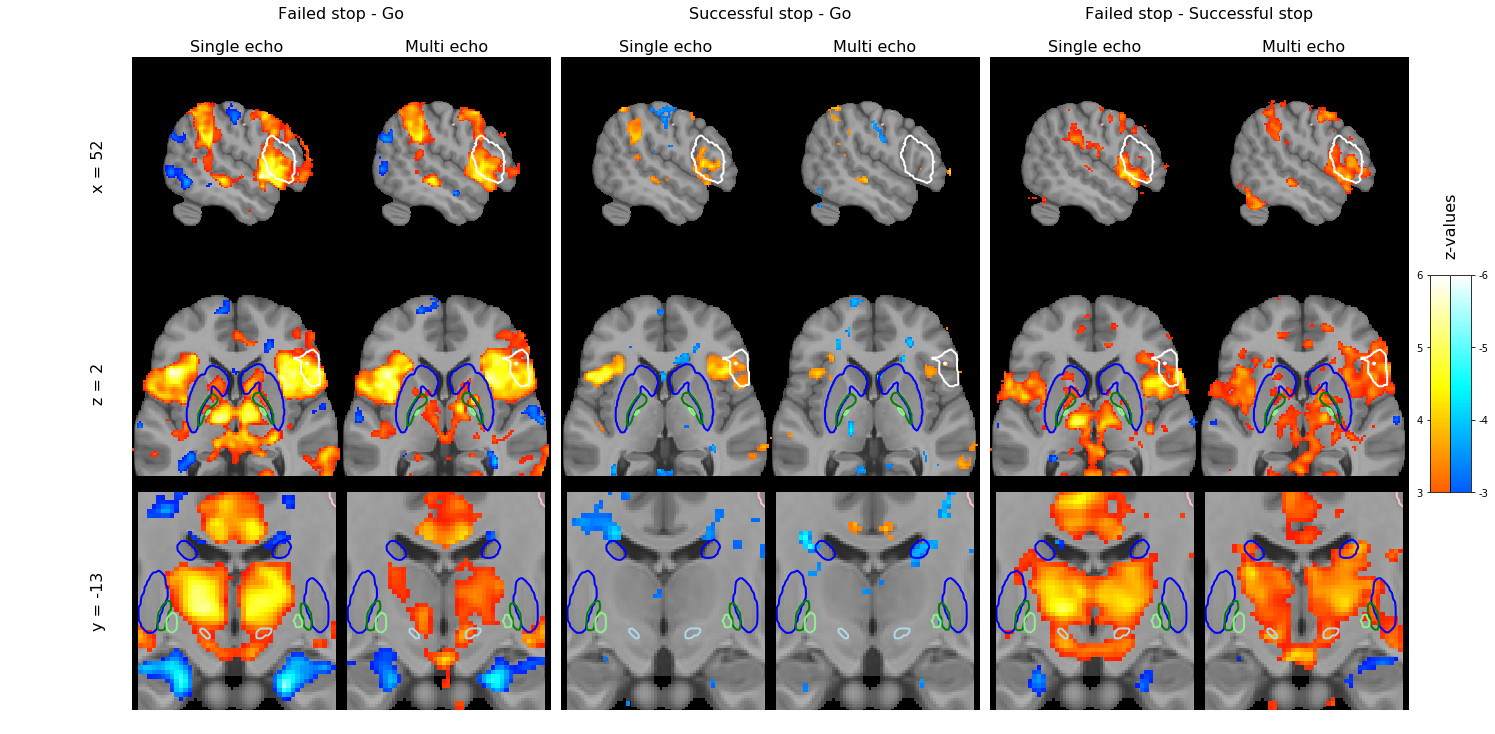

In [10]:
f, axes = plot_3x6(zmaps_combined, 
                   thresholds_combined, 
                   contrast_names=('Failed stop - Go', 
                                   'Successful stop - Go',
                                   'Failed stop - Successful stop')
                   )

## Plot 2: Events against baseline, classical correction


In [10]:
contrasts = {'failed_stop': 'failed_stop',
             'successful_stop': 'successful_stop',
             'go_trial': 'go_trial'}

slm_me = SLM(first_level_models_me, contrasts, smoothing_fwhm=5, height_control='fdr').fit()
slm_se = SLM(first_level_models_se, contrasts, smoothing_fwhm=5, height_control='fdr').fit()

zmaps_combined, thresholds_combined = order_maps_thresholds([slm_se.zmaps, slm_me.zmaps], 
                                                            [slm_se.thresholds, slm_me.thresholds])

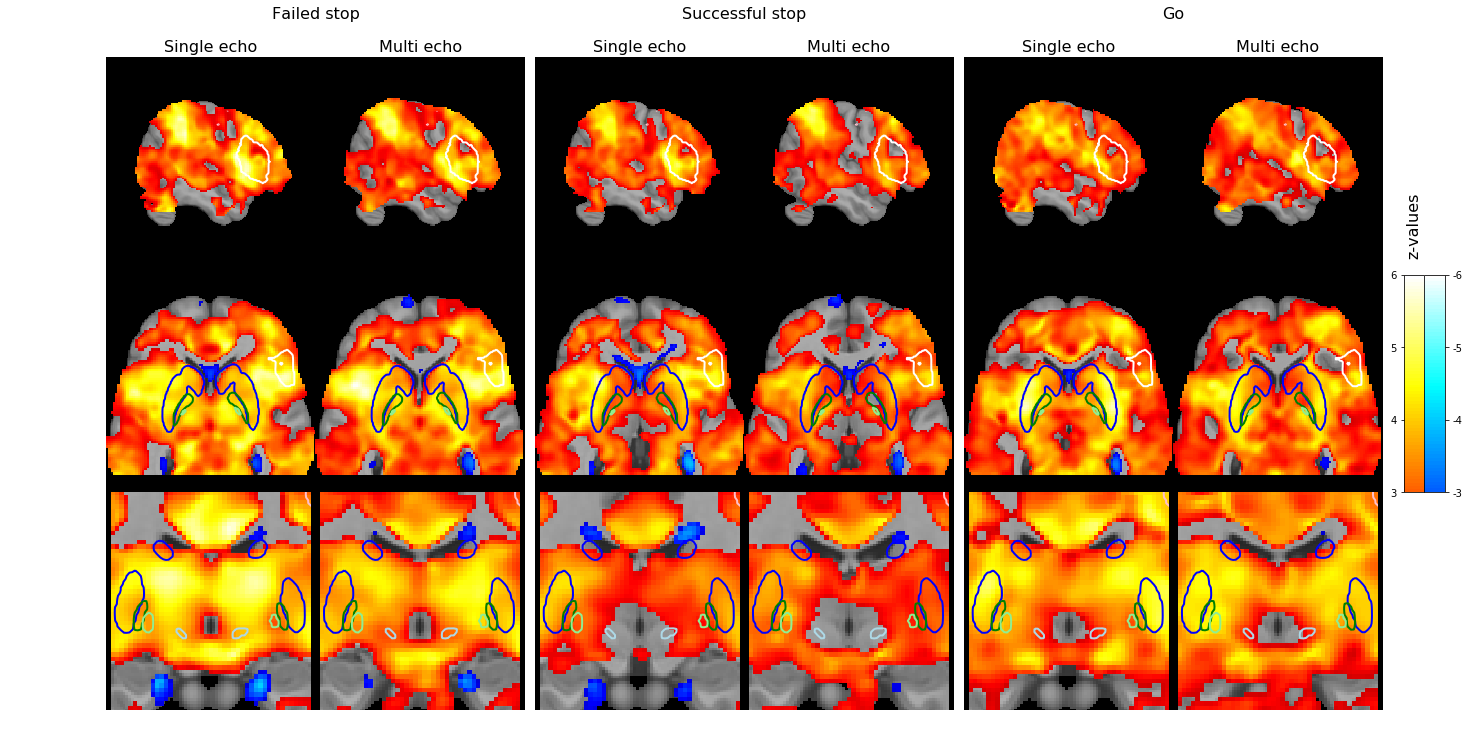

In [11]:
_ = plot_3x6(zmaps_combined, thresholds_combined, contrast_names=('Failed stop', 
                                                                  'Successful stop',
                                                                  'Go'))

## Plot 3: Events against baseline, derivatives, classical correction

In [12]:
contrasts = {'failed_stop_derivative': 'failed_stop_derivative',
             'successful_stop_derivative': 'successful_stop_derivative',
             'go_trial_derivative': 'go_trial_derivative'}

slm_me = SLM(first_level_models_me, contrasts, smoothing_fwhm=5, height_control='fdr').fit()
slm_se = SLM(first_level_models_se, contrasts, smoothing_fwhm=5, height_control='fdr').fit()

zmaps_combined, thresholds_combined = order_maps_thresholds([slm_se.zmaps, slm_me.zmaps], 
                                                            [slm_se.thresholds, slm_me.thresholds])

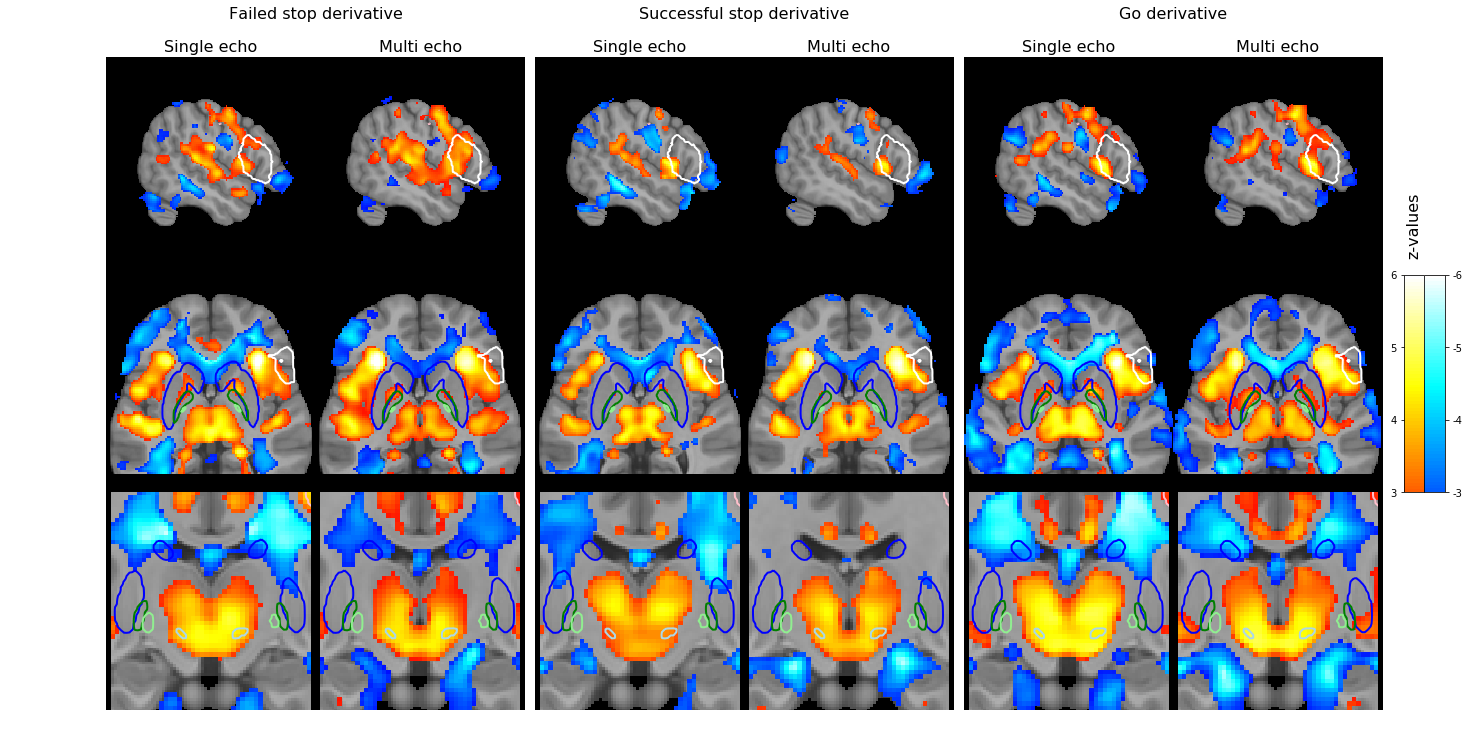

In [13]:
_ = plot_3x6(zmaps_combined, thresholds_combined, contrast_names=('Failed stop derivative', 
                                                                  'Successful stop derivative',
                                                                  'Go derivative'))

## Plot 4: Derivatives contrasts, classical correction

In [14]:
contrasts = {'failed_stop_derivative - go_trial_derivative': 'go_trial_derivative',
             'successful_stop_derivative - go_trial_derivative': 'successful_stop_derivative - go_trial_derivative',
             'failed_stop_derivative - successful_stop_derivative': 'failed_stop_derivative - successful_stop_derivative'}

slm_me = SLM(first_level_models_me, contrasts, smoothing_fwhm=5, height_control='fdr').fit()
slm_se = SLM(first_level_models_se, contrasts, smoothing_fwhm=5, height_control='fdr').fit()

zmaps_combined, thresholds_combined = order_maps_thresholds([slm_se.zmaps, slm_me.zmaps], 
                                                            [slm_se.thresholds, slm_me.thresholds])

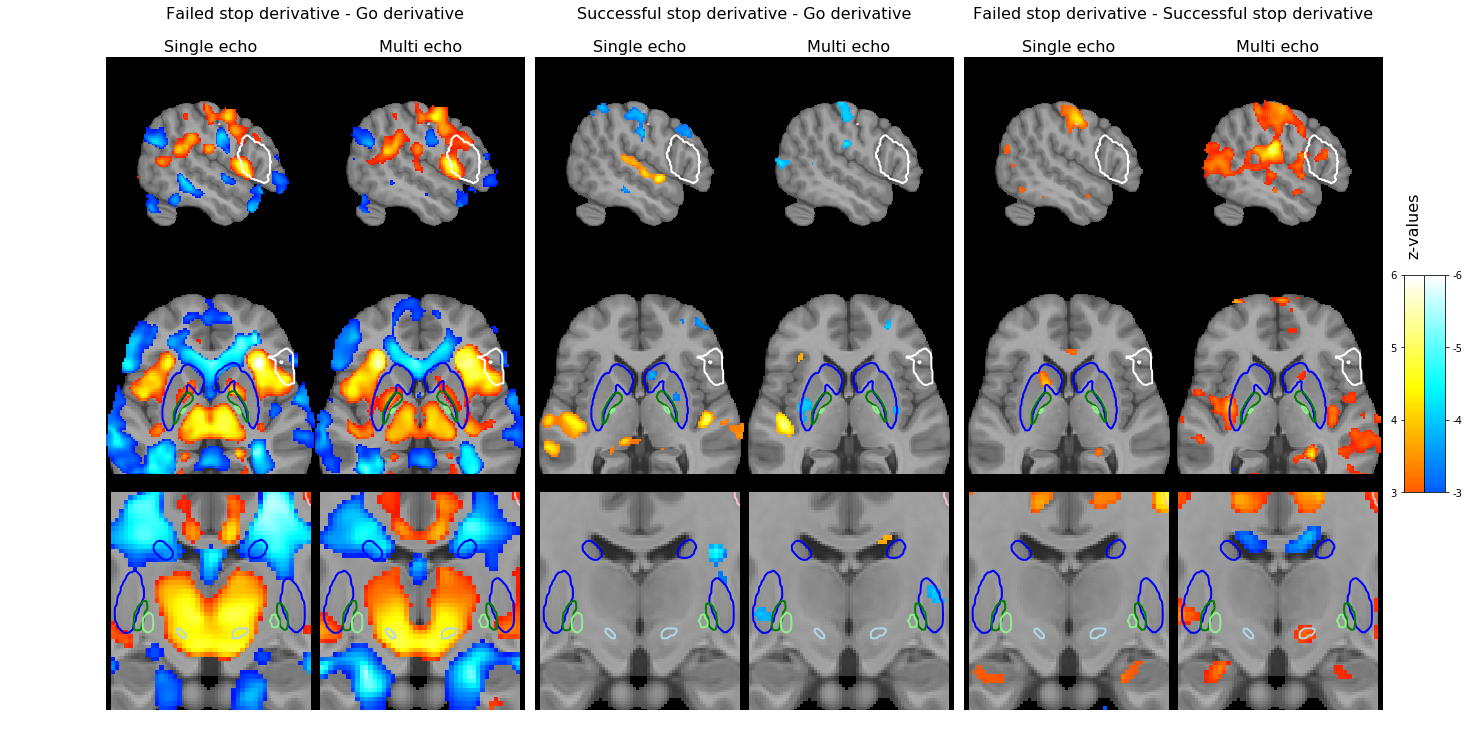

In [15]:
_ = plot_3x6(zmaps_combined, thresholds_combined, contrast_names=('Failed stop derivative - Go derivative', 
                                                                  'Successful stop derivative - Go derivative',
                                                                  'Failed stop derivative - Successful stop derivative'))

# Denoised data
Multi-echo data was denoised using local contrast & time denoising (LCaT-me), developed by Pilou. Unfortunately the results don't indicate a large difference..

In [28]:
# load data
first_level_models_meden = []
for sub in np.arange(1, 19):
    sub_str = str(sub).zfill(2)
    print(sub_str)
    if sub == 12:
        continue
    model = FirstLevels(sub_str, 'me', 
                        bids_root='./data/deriv/fmriprep/', 
                        bold_space='MNI152NLin2009cAsym',
                        me_combination_method='optcomb',
                        highpassed_data=True, denoised=True,
                        smooth_fwhm=5)
    model.fit_first_level(n_jobs=-17, overwrite=False, include_confounds=include_confounds, slice_time_ref=0.5, drift_model=None)
    first_level_models_meden.append(model.first_level_model)

01
Fitting first level model...


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as 

02
Fitting first level model...
03
Fitting first level model...
04
Fitting first level model...
05
Fitting first level model...
06
Fitting first level model...
07
Fitting first level model...
08
Fitting first level model...
09
Fitting first level model...
10
Fitting first level model...
11
Fitting first level model...
12
13
Fitting first level model...
14
Fitting first level model...
15
Fitting first level model...
16
Fitting first level model...
17
Fitting first level model...
18
Fitting first level model...


In [33]:
contrasts = {'failed_stop': 'failed_stop',
             'successful_stop': 'successful_stop',
             'go_trial': 'go_trial'}

slm_me = SLM(first_level_models_me, contrasts, smoothing_fwhm=0, height_control='fdr').fit()
slm_meden = SLM(first_level_models_meden, contrasts, smoothing_fwhm=5, height_control='fdr').fit()

zmaps_combined, thresholds_combined = order_maps_thresholds([slm_me.zmaps, slm_meden.zmaps], 
                                                            [slm_me.thresholds, slm_meden.thresholds])

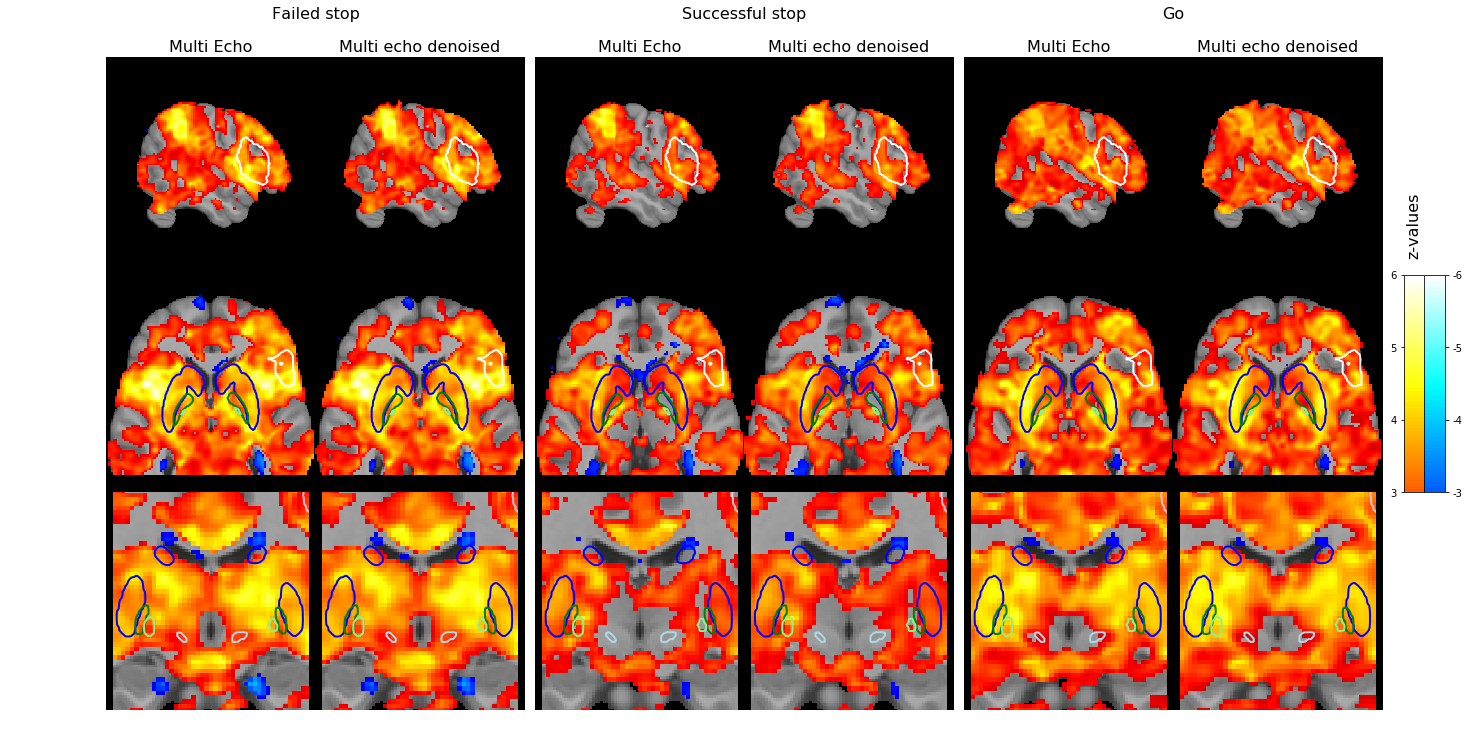

In [34]:
_ = plot_3x6(zmaps_combined, thresholds_combined, contrast_names=('Failed stop', 
                                                                  'Successful stop',
                                                                  'Go'),
             titles=('Multi Echo', 'Multi echo denoised', 'Multi Echo', 'Multi echo denoised', 'Multi Echo', 'Multi echo denoised'))

In [35]:
contrasts = {'failed_stop - go_trial': 'failed_stop - go_trial',
             'successful_stop - go_trial': 'successful_stop - go_trial',
             'failed_stop - successful_stop': 'failed_stop - successful_stop'}

slm_se = SLM(first_level_models=first_level_models_se, contrasts=contrasts, session='se', model_dir='model', 
             smoothing_fwhm=0, height_control='fdr').fit()
slm_meden = SLM(first_level_models_meden, contrasts, smoothing_fwhm=5, height_control='fdr').fit()

zmaps_combined, thresholds_combined = order_maps_thresholds([slm_se.zmaps, slm_meden.zmaps], 
                                                            [slm_se.thresholds, slm_meden.thresholds])

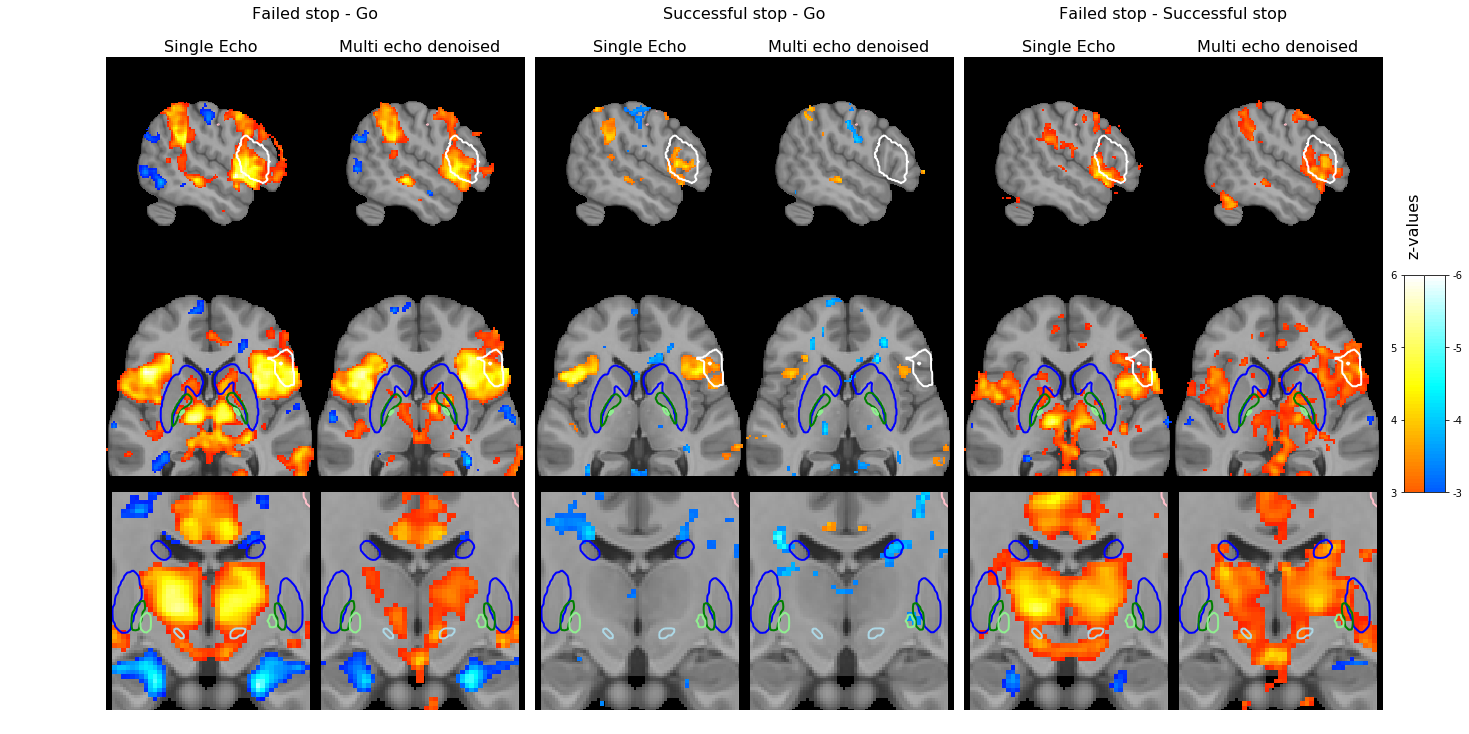

In [36]:
_ = plot_3x6(zmaps_combined, thresholds_combined, contrast_names=('Failed stop - Go', 
                             'Successful stop - Go',
                             'Failed stop - Successful stop'),
             titles=('Single Echo', 'Multi echo denoised', 
                     'Single Echo', 'Multi echo denoised', 
                     'Single Echo', 'Multi echo denoised'))

## GLM by echo

Compare the results across echos

In [8]:
first_level_models_echo_1 = []
first_level_models_echo_2 = []
first_level_models_echo_3 = []

for sub in np.arange(1, 19):
    sub_str = str(sub).zfill(2)
    print(sub_str)
    if sub == 12:
        continue
    
    for echo_n, list_ in zip(np.arange(1,4), [first_level_models_echo_1,
                                              first_level_models_echo_2,
                                              first_level_models_echo_3]):
        # load me
        model = FirstLevels(sub_str, 'me', 
                            bids_root='./data/deriv/fmriprep/', 
                            bold_space='MNI152NLin2009cAsym',
                            me_combination_method=None,
                            echo_n=echo_n, smooth_fwhm=5,
                            highpassed_data=True)
        model.fit_first_level(n_jobs=-10, 
                              drift_model=None,
                              smoothing_fwhm=5, 
                              include_confounds=include_confounds, overwrite=True, 
                              slice_time_ref=0.5)
        model.compute_contrasts(contrasts)
        list_.append(model.first_level_model)

01
Fitting first level model...


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as 

Contrast file found, loading from file...
Fitting first level model...


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/first_level_model.py:126: RuntimeWarning: invalid value encountered in true_divide
  (ols_result.resid ** 2).sum(axis=0))


Contrast file found, loading from file...
Fitting first level model...
Contrast file found, loading from file...
02
Fitting first level model...
Contrast file found, loading from file...
Fitting first level model...
Contrast file found, loading from file...
Fitting first level model...
Contrast file found, loading from file...
03
Fitting first level model...
Contrast file found, loading from file...
Fitting first level model...
Contrast file found, loading from file...
Fitting first level model...
Contrast file found, loading from file...
04
Fitting first level model...
Contrast file found, loading from file...
Fitting first level model...
Contrast file found, loading from file...
Fitting first level model...
Contrast file found, loading from file...
05
Fitting first level model...
Contrast file found, loading from file...
Fitting first level model...
Contrast file found, loading from file...
Fitting first level model...
Contrast file found, loading from file...
06
Fitting first level 

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Computing contrast successful_stop - go_trial...
Computing contrast failed_stop - successful_stop...
Fitting first level model...
Computing contrast failed_stop - go_trial...


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/utils.py:286: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)


Computing contrast successful_stop - go_trial...
Computing contrast failed_stop - successful_stop...
Fitting first level model...
Computing contrast failed_stop - go_trial...
Computing contrast successful_stop - go_trial...
Computing contrast failed_stop - successful_stop...
15
Fitting first level model...
Computing contrast failed_stop - go_trial...
Computing contrast successful_stop - go_trial...
Computing contrast failed_stop - successful_stop...
Fitting first level model...
Computing contrast failed_stop - go_trial...
Computing contrast successful_stop - go_trial...
Computing contrast failed_stop - successful_stop...
Fitting first level model...
Computing contrast failed_stop - go_trial...
Computing contrast successful_stop - go_trial...
Computing contrast failed_stop - successful_stop...
16
Fitting first level model...
Computing contrast failed_stop - go_trial...
Computing contrast successful_stop - go_trial...
Computing contrast failed_stop - successful_stop...
Fitting first leve

In [9]:
contrasts = {'failed_stop - go_trial': 'failed_stop - go_trial',
             'successful_stop - go_trial': 'successful_stop - go_trial',
             'failed_stop - successful_stop': 'failed_stop - successful_stop'}

slm_e1 = SLM(first_level_models_echo_1, contrasts=contrasts, smoothing_fwhm=5, height_control='fdr').fit()
slm_e2 = SLM(first_level_models_echo_2, contrasts=contrasts, smoothing_fwhm=5, height_control='fdr').fit()
slm_e3 = SLM(first_level_models_echo_3, contrasts=contrasts, smoothing_fwhm=5, height_control='fdr').fit()

zmaps_combined, thresholds_combined = order_maps_thresholds([slm_e1.zmaps, slm_e2.zmaps, slm_e3.zmaps], 
                                                            [slm_e1.thresholds, slm_e2.thresholds, slm_e3.thresholds])

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


Text(0.5, 1.0, 'z-values')

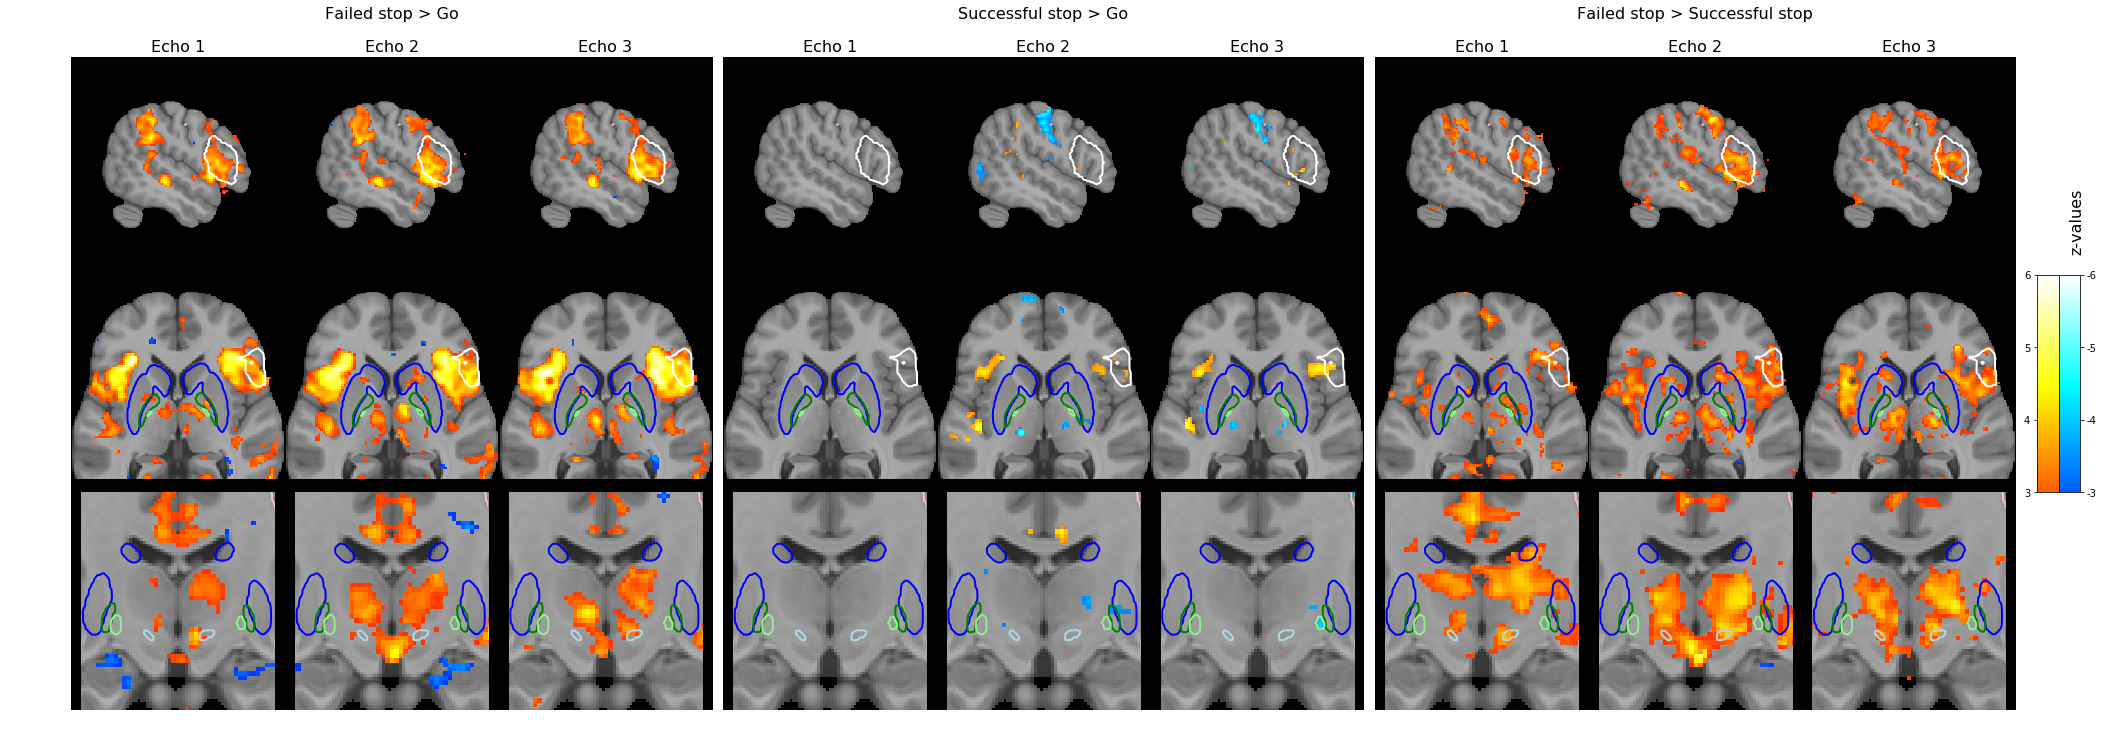

In [41]:
from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1, 1, 1, 0.05, 1, 1, 1, .05, 1, 1, 1, .1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps_combined)+5, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps_combined)+5, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps_combined, roi_dict=get_roi_dict(), z_threshold=thresholds_combined,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[52], None, [-13]],
                          bg_img='/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii',
                          vmax=6, #colorbar=False, 
                          plot_columns=(0,1,2,4,5,6,8,9,10),
                          annotate=False, empty_plots=False, 
                          skip_all_but_last=False)
axes[0,0].set_title('Echo 1', size=16)
axes[0,1].set_title('Echo 2', size=16)
axes[0,2].set_title('Echo 3', size=16)
axes[0,4].set_title('Echo 1', size=16)
axes[0,5].set_title('Echo 2', size=16)
axes[0,6].set_title('Echo 3', size=16)
axes[0,8].set_title('Echo 1', size=16)
axes[0,9].set_title('Echo 2', size=16)
axes[0,10].set_title('Echo 3', size=16)

for row in range(axes.shape[0]):
    axes[row,3].set_visible(False)
    axes[row,7].set_visible(False)
    axes[row,11].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)
    
# for titles: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
ext = []
#loop over the columns (j) and rows(i) to populate subplots
for j in range(11):
    # save the axes bounding boxes for later use
    ext.append([axes[0,j].get_window_extent().x0, axes[0,j].get_window_extent().width ])

# make nice
inv = f.transFigure.inverted()
width_left = ext[0][0]+(ext[2][0]+ext[2][1]-ext[0][0])/2.
left_center = inv.transform( (width_left, 1) )

width_mid = ext[4][0]+(ext[6][0]+ext[6][1]-ext[4][0])/2.
mid_center = inv.transform( (width_mid, 1) )

width_right = ext[8][0]+(ext[10][0]+ext[10][1]-ext[8][0])/2.
right_center = inv.transform( (width_right, 1) )

# set column spanning title 
# the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
plt.figtext(left_center[0], .93, "Failed stop > Go", va="center", ha="center", size=16)
plt.figtext(mid_center[0], .93, "Successful stop > Go", va="center", ha="center", size=16)
plt.figtext(right_center[0], .93, "Failed stop > Successful stop", va="center", ha="center", size=16)

# colorbar
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax2 = f.add_subplot(gs[1,-1])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, truncation_limits=(3,6), offset=thresholds_combined[0], flip=False)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=cbar_ax2, truncation_limits=(-3,-6), offset=thresholds_combined[0], flip=True)
cbar_ax2.set_title('z-values', rotation=90, fontsize=16, ha='left', pad=75)

# f.savefig('./glm.pdf')#, bbox_inches='tight')

# LISA
## Plot 1: Contrasts

In [ ]:
contrasts = {'failed_stop-go_trial': 'failed_stop - go_trial',
             'successful_stop-go_trial': 'successful_stop - go_trial',
             'failed_stop-successful_stop': 'failed_stop - successful_stop'}

slm_se_lisa1 = SLM(first_level_models=first_level_models_se, 
                   contrasts=contrasts, session='se', model_dir='model', height_control='LISA', 
                   bids_root='/home/stevenm/MultiEchoEPISeq/data/deriv/fmriprep',
                   save_dir='./second_level_models_lisa/single_echo').fit()
slm_me_lisa1 = SLM(first_level_models=first_level_models_me,
                   contrasts=contrasts, session='me', model_dir='model', height_control='LISA', 
                   bids_root='/home/stevenm/MultiEchoEPISeq/data/deriv/fmriprep',
                   save_dir='./second_level_models_lisa/multi_echo').fit()

In [ ]:
zmaps_combined = order_maps_thresholds([slm_se_lisa1.zmaps, slm_me_lisa1.zmaps])

def log10_transformed(hdr):
    dat = hdr.get_data().copy()
    return nib.Nifti1Image(-np.log10(1-dat), hdr.affine)

zmaps_transformed = [log10_transformed(zmap) for zmap in zmaps_combined]

_ = plot_3x6(zmaps_transformed, 0, contrast_names=('Failed stop - Go', 
                                                   'Successful stop - Go',
                                                   'Failed stop - Successful stop'),
             colorbars=((1.5, 3),), vmax=3)

## 2. Two-sided FDR

In [ ]:
contrasts = {'failed_stop-go_trial': 'failed_stop - go_trial',
             'successful_stop-go_trial': 'successful_stop - go_trial',
             'failed_stop-successful_stop': 'failed_stop - successful_stop'}

slm_se_lisa2 = SLM(first_level_models=first_level_models_se, level=0.025,
                   contrasts=contrasts, session='se', model_dir='model', height_control='LISA', 
                   bids_root='/home/stevenm/MultiEchoEPISeq/data/deriv/fmriprep',
                   save_dir='./second_level_models_lisa_alpha-p025/single_echo').fit()
slm_me_lisa2 = SLM(first_level_models=first_level_models_me, level=0.025,
                   contrasts=contrasts, session='me', model_dir='model', height_control='LISA', 
                   bids_root='/home/stevenm/MultiEchoEPISeq/data/deriv/fmriprep',
                   save_dir='./second_level_models_lisa_alpha-p025/multi_echo').fit()

In [ ]:
zmaps_combined = order_maps_thresholds([slm_se_lisa2.zmaps, slm_me_lisa2.zmaps])

def log10_transformed(hdr):
    dat = hdr.get_data().copy()
    return nib.Nifti1Image(-np.log10(1-dat), hdr.affine)

zmaps_transformed = [log10_transformed(zmap) for zmap in zmaps_combined]

_ = plot_3x6(zmaps_transformed, 0, contrast_names=('Failed stop - Go', 
                                                   'Successful stop - Go',
                                                   'Failed stop - Successful stop'),
             colorbars=((1.5, 3),), vmax=3)

## 3. Inverse contrast to get "negative" contrasts

In [ ]:
contrasts = {'go_trial-failed_stop': 'go_trial - failed_stop',
             'go_trial-successful_stop': 'go_trial - successful_stop',
             'successful_stop-failed_stop': 'successful_stop - failed_stop'}

slm_se_lisa3 = SLM(first_level_models=first_level_models_se, level=0.025,
                   contrasts=contrasts, session='se', model_dir='model', height_control='LISA', 
                   bids_root='/home/stevenm/MultiEchoEPISeq/data/deriv/fmriprep',
                   save_dir='./second_level_models_lisa_alpha-p025_inv/single_echo').fit()
slm_me_lisa3 = SLM(first_level_models=first_level_models_me, level=0.025,
                   contrasts=contrasts, session='me', model_dir='model', height_control='LISA', 
                   bids_root='/home/stevenm/MultiEchoEPISeq/data/deriv/fmriprep',
                   save_dir='./second_level_models_lisa_alpha-p025_inv/multi_echo').fit()

In [ ]:
zmaps_combined = order_maps_thresholds([slm_se_lisa3.zmaps, slm_me_lisa3.zmaps])

def log10_transformed(hdr):
    dat = hdr.get_data().copy()
    return nib.Nifti1Image(-np.log10(1-dat), hdr.affine)

zmaps_transformed = [log10_transformed(zmap) for zmap in zmaps_combined]

_ = plot_3x6(zmaps_transformed, 1.603, contrast_names=('Go - Failed stop', 
                                                       'Go - Successful stop',
                                                       'Successful stop - Failed stop'),
             colorbars=((1.5, 3), (1.5, 3)), vmax=3)

## 4. Combine zmaps to get LISA-controlled, 2-sided FDR-corrected p-maps

In [ ]:
def combine_zmaps(positive_map, negative_map):
    dat_pos = positive_map.get_data()
    dat_neg = negative_map.get_data()
    
    dat_pos[dat_neg>0] = -dat_neg[dat_neg>0]
    
    return nib.Nifti1Image(dat_pos, positive_map.affine)


zmaps_pos = order_maps_thresholds([slm_se_lisa2.zmaps, slm_me_lisa2.zmaps])
zmaps_neg = order_maps_thresholds([slm_se_lisa3.zmaps, slm_me_lisa3.zmaps])

zmaps_pos = [log10_transformed(zmap) for zmap in zmaps_pos]
zmaps_neg = [log10_transformed(zmap) for zmap in zmaps_neg]

zmaps_combined = [combine_zmaps(x, y) for x, y in zip(zmaps_pos, zmaps_neg)]

# zm1 = slm_se_lisa2.zmaps['successful_stop-go_trial']
# zm2 = slm_se_lisa3.zmaps['go_trial-successful_stop']
# zm_comb = combine_zmaps(zm1, zm2)

In [ ]:
_ = plot_3x6(zmaps_combined, 1.603, contrast_names=('Failed stop > Go', 
                                                    'Successful stop > Go',
                                                    'Failed stop > Successful stop'),
             colorbars=((1.603, 3), (1.603, 3)), vmax=3)

In [ ]:
# _ = plot_3x6(zmaps_combined, 1.603, contrast_names=('Failed stop > Go', 
#                                                 'Successful stop > Go',
#                                                 'Failed stop > Successful stop'),
#              colorbars=((1.5, 3), (-1.5, -3)), vmax=3)

KeyError: 'failed_stop-go_trial'

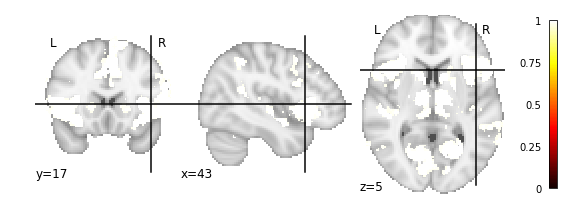

In [113]:
# # combine z-maps
# plotting.plot_stat_map(slm_se_lisa2.zmaps['failed_stop-go_trial'])
# plotting.plot_stat_map(slm_se_lisa3.zmaps['failed_stop-go_trial'])


## Plot 2: PEs for event types

In [27]:
contrasts = {'failed_stop': 'failed_stop',
             'successful_stop': 'successful_stop ',
             'go_trial': 'go_trial'}

slm_se_lisa2 = SLM(first_level_models_se, contrasts=contrasts, height_control='LISA').fit()
slm_me_lisa2 = SLM(first_level_models_me, contrasts=contrasts, height_control='LISA').fit()

KeyboardInterrupt: 

In [ ]:
zmaps_combined = order_maps_thresholds([slm_se_lisa2.zmaps, slm_me_lisa2.zmaps])

zmaps_transformed = [log10_transformed(zmap) for zmap in zmaps_combined]

_ = plot_3x6(zmaps_combined, 0, contrast_names=('Failed stop', 
                                                'Successful stop',
                                                'Go'),
             colorbars=((.95, 1),))

## Motor responses

In [21]:
n_jobs = 1
overwrite = False
models_dir_name = 'model-motor-responses'
events = ('response_left', 'response_right')
contrasts = ['response_left - response_right']

# loop the loop
for sub in range(1,19):
    sub_str = str(sub).zfill(2)
    if sub == 17:
        runs = [1,2]
    else:
        runs = [1,2,3]

    for ses in ['me', 'se']:
        if ses=='me':
            if sub == 12:
                # sub 12, ses-me failed: pp could not hear audio. SE was fine though
                continue
                
            # Combined multi-echo data (loop because at some point I also tried PAID, but not really different from OC)
            for me_comb in ['optcomb']:
                print('Subject {}, session {}, {}... '.format(sub_str, ses, me_comb), end='')

                model = FirstLevels(sub_str, ses, 
                                    bids_root='./data/deriv/fmriprep/', 
                                    bold_space='MNI152NLin2009cAsym',
                                    me_combination_method=me_comb,
                                    models_dir_name=models_dir_name,
                                    runs=runs,
                                    denoised=False,
                                    highpassed_data=True)
                model.fit_first_level(n_jobs=n_jobs, events=events,
                                      include_confounds=include_confounds, smoothing_fwhm=0, 
                                      drift_model=None, overwrite=overwrite, slice_time_ref=0.5)
                model.compute_contrasts(contrasts, overwrite=overwrite)
            
#             # Denoise multi-echo data
#             print('Subject {}, session {}, denoised... '.format(sub_str, ses), end='')
#             model = FirstLevels(sub_str, session='me', 
#                                 bids_root='./data/deriv/fmriprep/', 
#                                 bold_space='MNI152NLin2009cAsym',
#                                 me_combination_method=me_comb,
#                                 models_dir_name=models_dir_name,
#                                 runs=runs,
#                                 denoised=True,
#                                 highpassed_data=True)
#             model.fit_first_level(n_jobs=n_jobs, events=events,
#                                   include_confounds=include_confounds, smoothing_fwhm=0, 
#                                   drift_model=None, overwrite=overwrite, slice_time_ref=0.5)
#             model.compute_contrasts(contrasts, overwrite=overwrite)
            
#             # Multi-echo data, per echo separately
#             for echo_n in [1,2,3]:
#                 print('Subject {}, session {}, echo {}... '.format(sub_str, ses, echo_n), end='')
#                 model = FirstLevels(sub_str, ses, 
#                                     bids_root='./data/deriv/fmriprep/', 
#                                     bold_space='MNI152NLin2009cAsym',
#                                     me_combination_method=None,
#                                     models_dir_name=models_dir_name,
#                                     runs=runs,
#                                     echo_n=echo_n,
#                                     highpassed_data=True)
#                 model.fit_first_level(n_jobs=n_jobs, events=events,
#                                       include_confounds=include_confounds, smoothing_fwhm=0, 
#                                       drift_model=None, overwrite=overwrite, slice_time_ref=0.5)
#                 model.compute_contrasts(contrasts, overwrite=overwrite)
        else:
            # Single-echo data
            print('Subject {}, session {}... '.format(sub_str, ses), end='')
            model = FirstLevels(sub_str, ses, 
                        bids_root='./data/deriv/fmriprep/', 
                        bold_space='MNI152NLin2009cAsym',
                        models_dir_name=models_dir_name,
                        runs=runs, highpassed_data=True)
            model.fit_first_level(n_jobs=n_jobs, events=events,
                                  include_confounds=include_confounds, smoothing_fwhm=0,
                                  drift_model=None, overwrite=overwrite, slice_time_ref=0.5)
            model.compute_contrasts(contrasts, overwrite=overwrite)

Subject 01, session me, optcomb... Fitting first level model...


KeyboardInterrupt: 

In [63]:
ses = 'se'
me_comb = 'optcomb'  # or PAID
all_data_se = []
all_confounds_se = []
all_onsets_se = []

all_data_me = []
all_confounds_me = []
all_onsets_me = []

smooth = 5

for sub in np.arange(1, 19):
    sub_str = str(sub).zfill(2)
    print(sub_str)
    if sub == 12:
        continue
    
    # load se
    model = FirstLevels(sub_str, 'se', 
                        bids_root='./data/deriv/fmriprep/', 
                        bold_space='MNI152NLin2009cAsym',
                        me_combination_method=None,
                        highpassed_data=True,
                        smooth_fwhm=smooth)
    all_data_se += model.get_data_mask_confounds()[0]
    all_onsets_se += [model.get_onsets(x, events=events) for x in model.runs]

    confounds = model.get_data_mask_confounds()[2]
    all_confounds_se += [model.load_confounds(x, include_confounds=include_confounds) for x in confounds]

    
    # load me
    model = FirstLevels(sub_str, 'me', 
                        bids_root='./data/deriv/fmriprep/', 
                        bold_space='MNI152NLin2009cAsym',
                        me_combination_method=me_comb,
                        highpassed_data=True,
                        smooth_fwhm=smooth)
    all_data_me += model.get_data_mask_confounds()[0]
    all_onsets_me += [model.get_onsets(x, events=events) for x in model.runs]
    
    confounds = model.get_data_mask_confounds()[2]
    all_confounds_me += [model.load_confounds(x, include_confounds=include_confounds) for x in confounds]

01
02
03
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18


In [64]:
mask = model.get_data_mask_confounds()[1]
mask

'./data/deriv/fmriprep/sub-18/ses-me/func/sub-18_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'

In [69]:
# Fixed effects analysis
mask = model.get_data_mask_confounds()[1]
second_level_model = FirstLevelModel(t_r=3, 
                                     hrf_model='glover + derivative', 
                                     smoothing_fwhm=5,
                                     mask=mask,
                                     n_jobs=-10, slice_time_ref=0.5, drift_model=None)
second_level_model.fit(all_data_me, all_onsets_me, all_confounds_me)

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as 

FirstLevelModel(drift_model=None, drift_order=1, fir_delays=[0],
        hrf_model='glover + derivative',
        mask='./data/deriv/fmriprep/sub-18/ses-me/func/sub-18_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
        memory=Memory(location=None), memory_level=1, min_onset=-24,
        minimize_memory=True, n_jobs=-10, noise_model='ar1',
        period_cut=128, signal_scaling=True, slice_time_ref=0.5,
        smoothing_fwhm=5, standardize=False, subject_label=None, t_r=3,
        target_affine=None, target_shape=None, verbose=0)

In [70]:
# Fixed effects analysis
mask = model.get_data_mask_confounds()[1]
second_level_model_se = FirstLevelModel(t_r=3, 
                                     hrf_model='glover + derivative', 
                                     smoothing_fwhm=5,
                                     mask=mask,
                                     n_jobs=-10, slice_time_ref=0.5, drift_model=None)
second_level_model_se.fit(all_data_se, all_onsets_se, all_confounds_se)

FirstLevelModel(drift_model=None, drift_order=1, fir_delays=[0],
        hrf_model='glover + derivative',
        mask='./data/deriv/fmriprep/sub-18/ses-me/func/sub-18_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
        memory=Memory(location=None), memory_level=1, min_onset=-24,
        minimize_memory=True, n_jobs=-10, noise_model='ar1',
        period_cut=128, signal_scaling=True, slice_time_ref=0.5,
        smoothing_fwhm=5, standardize=False, subject_label=None, t_r=3,
        target_affine=None, target_shape=None, verbose=0)

In [72]:
!mkdir second_level_FE_nistats

In [74]:
with open('./second_level_FE_nistats/me', 'wb') as f:
    pkl.dump(second_level_model, f)
with open('./second_level_FE_nistats/se', 'wb') as f:
    pkl.dump(second_level_model_se, f)

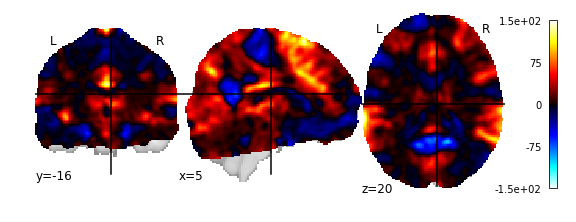

In [82]:
plotting.plot_stat_map(second_level_model.compute_contrast(['failed_stop - go_trial'], output_type='effect_size'),
                       vmax=150)

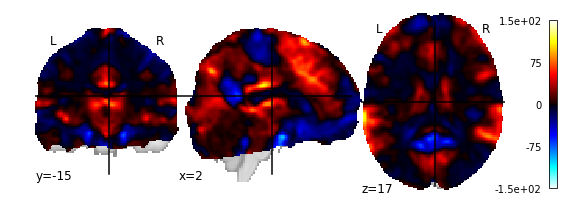

In [87]:
plotting.plot_stat_map(second_level_model_se.compute_contrast(['failed_stop - go_trial'], output_type='effect_size'),
                       vmax=150)

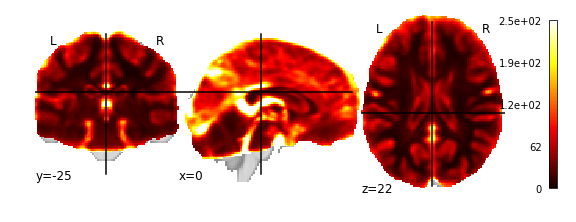

In [89]:
plotting.plot_stat_map(second_level_model.compute_contrast(['failed_stop - go_trial'], output_type='effect_variance'),
                       vmax=250)

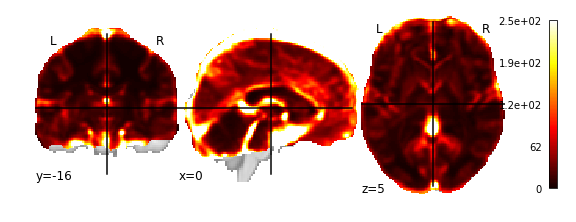

In [90]:
plotting.plot_stat_map(second_level_model_se.compute_contrast(['failed_stop - go_trial'], output_type='effect_variance'),
                       vmax=250)

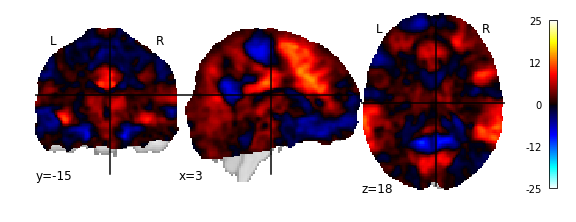

In [97]:
plotting.plot_stat_map(second_level_model.compute_contrast(['failed_stop - go_trial'], output_type='stat'),
                       vmax=25)

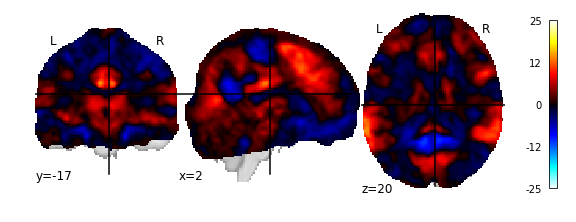

In [98]:
plotting.plot_stat_map(second_level_model_se.compute_contrast(['failed_stop - go_trial'], output_type='stat'),
                       vmax=25)

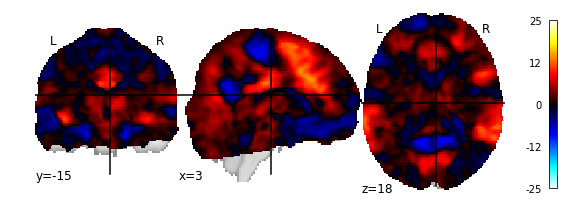

In [95]:
plotting.plot_stat_map(second_level_model.compute_contrast(['failed_stop - go_trial'], output_type='z_score'),
                       vmax=25)

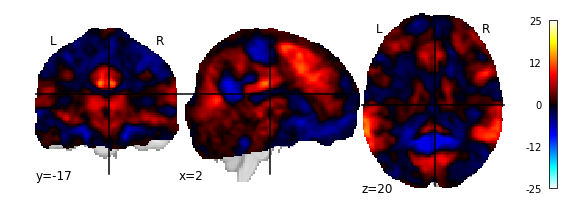

In [96]:
plotting.plot_stat_map(second_level_model_se.compute_contrast(['failed_stop - go_trial'], output_type='z_score'),
                       vmax=25)

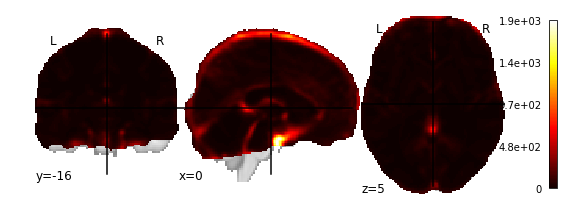

In [81]:
plotting.plot_stat_map(second_level_model_se.compute_contrast(['failed_stop - go_trial'],
                                                              output_type='effect_variance'))

## Mean t-values over participants

In [102]:
all_tmaps_se = [x.compute_contrast(['failed_stop - go_trial'], output_type='stat') for x in first_level_models_se]

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


In [103]:
all_tmaps_me = [x.compute_contrast(['failed_stop - go_trial'], output_type='stat') for x in first_level_models_me]

In [106]:
mean_tmap_se = nib.Nifti1Image(nilearn.image.concat_imgs(all_tmaps_se).get_data().mean(3), affine=all_tmaps_se[0].affine)
mean_tmap_me = nib.Nifti1Image(nilearn.image.concat_imgs(all_tmaps_me).get_data().mean(3), affine=all_tmaps_se[0].affine)

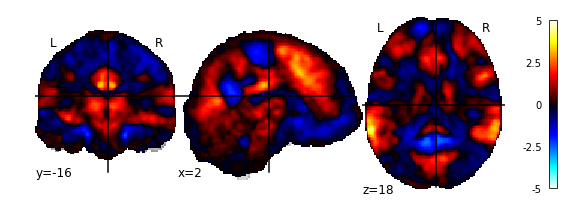

In [109]:
plotting.plot_stat_map(mean_tmap_se, vmax=5)

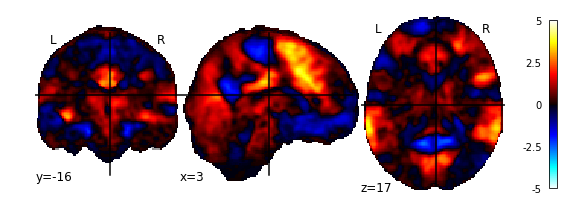

In [110]:
plotting.plot_stat_map(mean_tmap_me, vmax=5)

## old stuf below

Requires a list of contrast maps (t-values) per contrast, so let's make them

In [44]:
n_jobs = 1
overwrite = False

me_t_maps_failed_go = []
se_t_maps_failed_go = []
me_t_maps_failed_success = []
se_t_maps_failed_success = []
me_t_maps_success_go = []
se_t_maps_success_go = []

# loop the loop
for sub in range(1,19):
    sub_str = str(sub).zfill(2)
    if sub == 12:
        # sub 12, ses-me failed: pp could not hear audio. SE was fine though
        continue

    if sub == 17:
        runs = [1,2]
    else:
        runs = [1,2,3]

    for ses in ['me', 'se']:
        if ses=='me':
            # combinations first
            for me_comb in ['optcomb']:
                print('Subject {}, session {}, {}... '.format(sub_str, ses, me_comb), end='')

                model = FirstLevels(sub_str, ses, 
                                    bids_root='./data/deriv/fmriprep/', 
                                    bold_space='MNI152NLin2009cAsym',
                                    me_combination_method=me_comb,
                                    runs=runs,
                                    denoised=False,
                                    highpassed_data=True)
                model.fit_first_level(n_jobs=n_jobs, include_confounds=include_confounds, smoothing_fwhm=0, 
                                      drift_model=None, overwrite=overwrite)
                model.compute_contrasts(contrasts, overwrite=overwrite)
                me_t_maps_failed_go.append(model.first_level_model.compute_contrast(['failed_stop - go_trial'], stat_type='t', output_type='stat'))
                me_t_maps_failed_success.append(model.first_level_model.compute_contrast(['failed_stop - successful_stop'], stat_type='t', output_type='stat'))
                me_t_maps_success_go.append(model.first_level_model.compute_contrast(['successful_stop - go_trial'], stat_type='t', output_type='stat'))

    else:
            print('Subject {}, session {}... '.format(sub_str, ses), end='')
            model = FirstLevels(sub_str, ses, 
                        bids_root='./data/deriv/fmriprep/', 
                        bold_space='MNI152NLin2009cAsym',
                        runs=runs, highpassed_data=True)
            model.fit_first_level(n_jobs=n_jobs, include_confounds=include_confounds, smoothing_fwhm=0,
                                  drift_model=None, overwrite=overwrite)
            model.compute_contrasts(contrasts, overwrite=overwrite)
            se_t_maps_failed_go.append(model.first_level_model.compute_contrast(['failed_stop - go_trial'], stat_type='t', output_type='stat'))
            se_t_maps_failed_success.append(model.first_level_model.compute_contrast(['failed_stop - successful_stop'], stat_type='t', output_type='stat'))
            se_t_maps_success_go.append(model.first_level_model.compute_contrast(['successful_stop - go_trial'], stat_type='t', output_type='stat'))

Subject 01, session me, optcomb... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 01, session se... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 02, session me, optcomb... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 02, session se... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 03, session me, optcomb... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 03, session se... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 04, session me, optcomb... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 04, session se... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 05, session me, optcomb... Model already exists, loading from file..

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Subject 17, session se... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 18, session me, optcomb... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 18, session se... Model already exists, loading from file...
Contrast file found, loading from file...


In [48]:
lisa_dir = './lisa_second_level'
subs = np.arange(1, 19)
subs = [x for x in subs if not x == 12]

# me
for sub, contr in zip(subs, me_t_maps_failed_go):
    fn = 'sub-{}_ses-me_contrast-failed-go_stat-t.nii.gz'.format(sub)
    nib.save(contr, os.path.join(lisa_dir, 'me', fn))
for sub, contr in zip(subs, me_t_maps_failed_success):
    fn = 'sub-{}_ses-me_contrast-failed-success_stat-t.nii.gz'.format(sub)
    nib.save(contr, os.path.join(lisa_dir, 'me', fn))
for sub, contr in zip(subs, me_t_maps_success_go):
    fn = 'sub-{}_ses-me_contrast-success-go_stat-t.nii.gz'.format(sub)
    nib.save(contr, os.path.join(lisa_dir, 'me', fn))

# se
for sub, contr in zip(subs, se_t_maps_failed_go):
    fn = 'sub-{}_ses-se_contrast-failed-go_stat-t.nii.gz'.format(sub)
    nib.save(contr, os.path.join(lisa_dir, 'se', fn))
for sub, contr in zip(subs, se_t_maps_failed_success):
    fn = 'sub-{}_ses-se_contrast-failed-success_stat-t.nii.gz'.format(sub)
    nib.save(contr, os.path.join(lisa_dir, 'se', fn))
for sub, contr in zip(subs, se_t_maps_success_go):
    fn = 'sub-{}_ses-se_contrast-success-go_stat-t.nii.gz'.format(sub)
    nib.save(contr, os.path.join(lisa_dir, 'se', fn))


#### Create command line cmds

In [164]:
#contrast_to_run = 'success-go'
# contrast_to_run = 'failed-go'
contrast_to_run = 'failed-success'
ses = 'se'

In [165]:
fns = glob.glob('./lisa_second_level/{}/sub-*_ses-{}_contrast-{}*.nii.gz'.format(ses, ses, contrast_to_run))
fns.sort()
fns = [x.replace('./lisa_second_level/{}'.format(ses), '/data') for x in fns]

cmd = ['docker', 'run', '-v', '/home/stevenm/MultiEchoEPISeq/lisa_second_level/{}:/data'.format(ses), 
       'lipsia', 'vlisa_onesample', '-in']
cmd += fns
cmd += ['-out', '/data/second_level_contrast-{}.v'.format(contrast_to_run), '-cleanup', 'false']
cmd = ' '.join(cmd)
cmd

'docker run -v /home/stevenm/MultiEchoEPISeq/lisa_second_level/se:/data lipsia vlisa_onesample -in /data/sub-10_ses-se_contrast-failed-success_stat-t.nii.gz /data/sub-11_ses-se_contrast-failed-success_stat-t.nii.gz /data/sub-13_ses-se_contrast-failed-success_stat-t.nii.gz /data/sub-14_ses-se_contrast-failed-success_stat-t.nii.gz /data/sub-15_ses-se_contrast-failed-success_stat-t.nii.gz /data/sub-16_ses-se_contrast-failed-success_stat-t.nii.gz /data/sub-17_ses-se_contrast-failed-success_stat-t.nii.gz /data/sub-18_ses-se_contrast-failed-success_stat-t.nii.gz /data/sub-1_ses-se_contrast-failed-success_stat-t.nii.gz /data/sub-2_ses-se_contrast-failed-success_stat-t.nii.gz /data/sub-3_ses-se_contrast-failed-success_stat-t.nii.gz /data/sub-4_ses-se_contrast-failed-success_stat-t.nii.gz /data/sub-5_ses-se_contrast-failed-success_stat-t.nii.gz /data/sub-6_ses-se_contrast-failed-success_stat-t.nii.gz /data/sub-7_ses-se_contrast-failed-success_stat-t.nii.gz /data/sub-8_ses-se_contrast-failed-suc

#### cmd to convert v-file to nifti

In [167]:
ses = 'se'
for v_file in glob.glob('./lisa_second_level/{}/*.v'.format(ses)):
    conv_cmd = ['docker', 'run', '-v', '/home/stevenm/MultiEchoEPISeq/lisa_second_level/{}:/data'.format(ses), 
       'lipsia', 'vnifti', '-in']
    fn = '/data/' + v_file.split('/')[-1]
    conv_cmd += [fn, '-out', fn.replace('.v', '.nii')]
    conv_cmd = ' '.join(conv_cmd)
    print(conv_cmd)

docker run -v /home/stevenm/MultiEchoEPISeq/lisa_second_level/se:/data lipsia vnifti -in /data/second_level_contrast-failed-success.v -out /data/second_level_contrast-failed-success.nii
docker run -v /home/stevenm/MultiEchoEPISeq/lisa_second_level/se:/data lipsia vnifti -in /data/second_level_contrast-failed-go.v -out /data/second_level_contrast-failed-go.nii
docker run -v /home/stevenm/MultiEchoEPISeq/lisa_second_level/se:/data lipsia vnifti -in /data/second_level_contrast-success-go.v -out /data/second_level_contrast-success-go.nii


In [161]:
## load & plot results

In [169]:
zmaps_se = [nib.load('./lisa_second_level/se/second_level_contrast-failed-go.nii'),
            nib.load('./lisa_second_level/se/second_level_contrast-success-go.nii'),
            nib.load('./lisa_second_level/se/second_level_contrast-failed-success.nii')
           ]
zmaps_me = [nib.load('./lisa_second_level/me/second_level_contrast-failed-go.nii'),
            nib.load('./lisa_second_level/me/second_level_contrast-success-go.nii'),
            nib.load('./lisa_second_level/me/second_level_contrast-failed-success.nii')
           ]

zmaps_combined = [zmaps_se[0], zmaps_me[0], 
                  zmaps_se[1], zmaps_me[1], 
                  zmaps_se[2], zmaps_me[2]]

In [194]:
def log10_transformed(hdr):
    dat = hdr.get_data()
    return nib.Nifti1Image(-np.log10(1-dat), hdr.affine)

zmaps_transformed = [log10_transformed(zmap) for zmap in zmaps_combined]

In [203]:
zmaps_transformed[0].get_data().max()

2.5492072

Text(0.5, 1.0, '-log_10(p-values)')

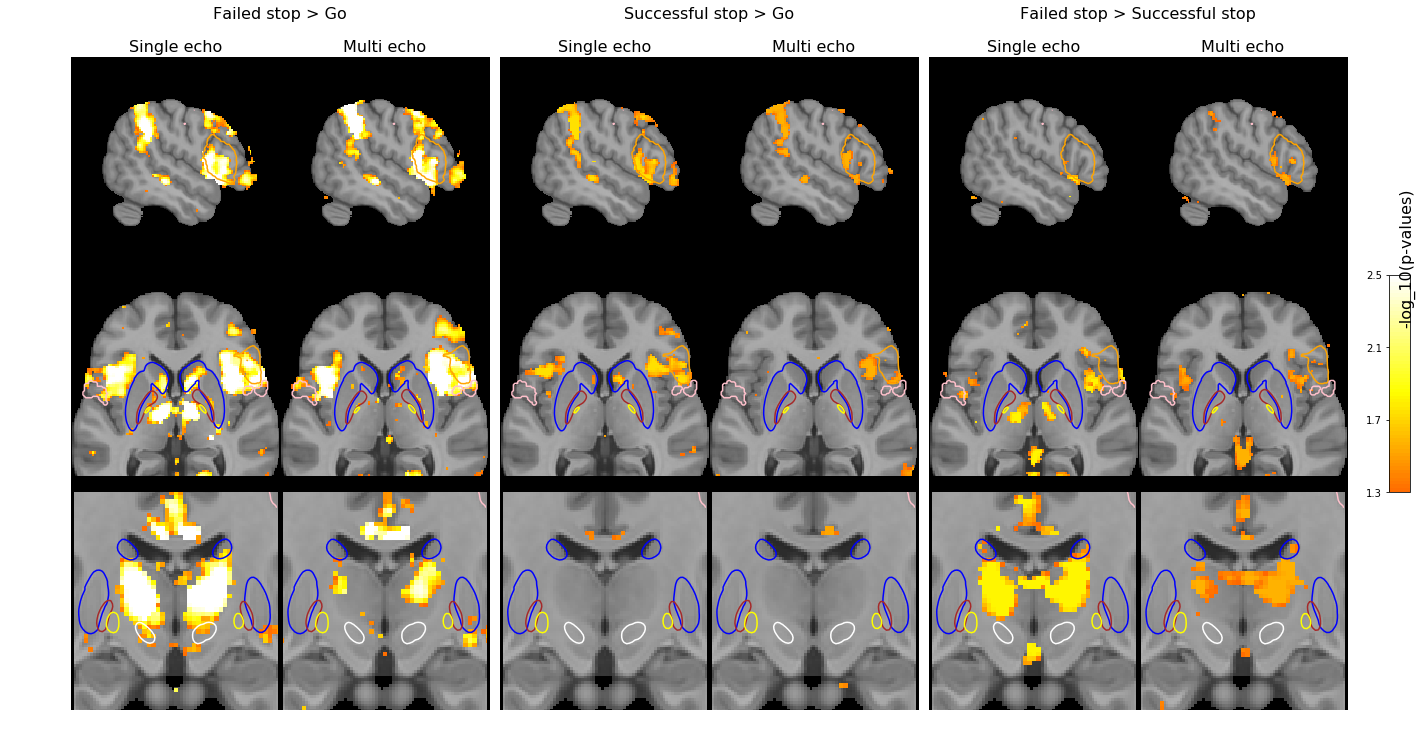

In [205]:
from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1, 1, 0.05, 1, 1, .05, 1, 1, .1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps_combined)+5, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps_combined)+5, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_secondlevel_results(zmaps_transformed, roi_dict, z_threshold=0,
                                          f=f, axes=axes,
                                          roi_to_plot=['rIFG', 'STR', 'STN'],
                                          cut_coords=[[52], None, [-13]],
                                          bg_img='/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii',
                                          vmax=2.5, #colorbar=False, 
                                          annotate=False, empty_plots=False, 
                                          skip_all_but_last=False)
axes[0,0].set_title('Single echo', size=16)
axes[0,1].set_title('Multi echo', size=16)
axes[0,3].set_title('Single echo', size=16)
axes[0,4].set_title('Multi echo', size=16)
axes[0,6].set_title('Single echo', size=16)
axes[0,7].set_title('Multi echo', size=16)

for row in range(axes.shape[0]):
    axes[row,2].set_visible(False)
    axes[row,5].set_visible(False)
    axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)
    
# for titles: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
ext = []
#loop over the columns (j) and rows(i) to populate subplots
for j in range(8):
    # save the axes bounding boxes for later use
    ext.append([axes[0,j].get_window_extent().x0, axes[0,j].get_window_extent().width ])

# make nice
inv = f.transFigure.inverted()
width_left = ext[0][0]+(ext[1][0]+ext[1][1]-ext[0][0])/2.
left_center = inv.transform( (width_left, 1) )

width_mid = ext[3][0]+(ext[4][0]+ext[4][1]-ext[3][0])/2.
mid_center = inv.transform( (width_mid, 1) )

width_right = ext[6][0]+(ext[7][0]+ext[7][1]-ext[6][0])/2.
right_center = inv.transform( (width_right, 1) )

# set column spanning title 
# the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
plt.figtext(left_center[0], .93, "Failed stop > Go", va="center", ha="center", size=16)
plt.figtext(mid_center[0], .93, "Successful stop > Go", va="center", ha="center", size=16)
plt.figtext(right_center[0], .93, "Failed stop > Successful stop", va="center", ha="center", size=16)


# colorbar
#cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax2 = f.add_subplot(gs[1,-1])

#cbar_ax1 = _draw_colorbarSM2(colorbar_ax=cbar_ax1, truncation_limits=(3,6), offset=0, flip=False)
cbar_ax2 = _draw_colorbarSM2(colorbar_ax=cbar_ax2, vmin=1.3, vmax=2.5,
                             truncation_limits=(1.3, 2.5), offset=1.3, flip=False)
cbar_ax2.set_title('-log_10(p-values)', rotation=90, fontsize=16, ha='left', pad=75)

# f.savefig('./glm.pdf')#, bbox_inches='tight')

Text(0.5, 1.0, '1 - p-values')

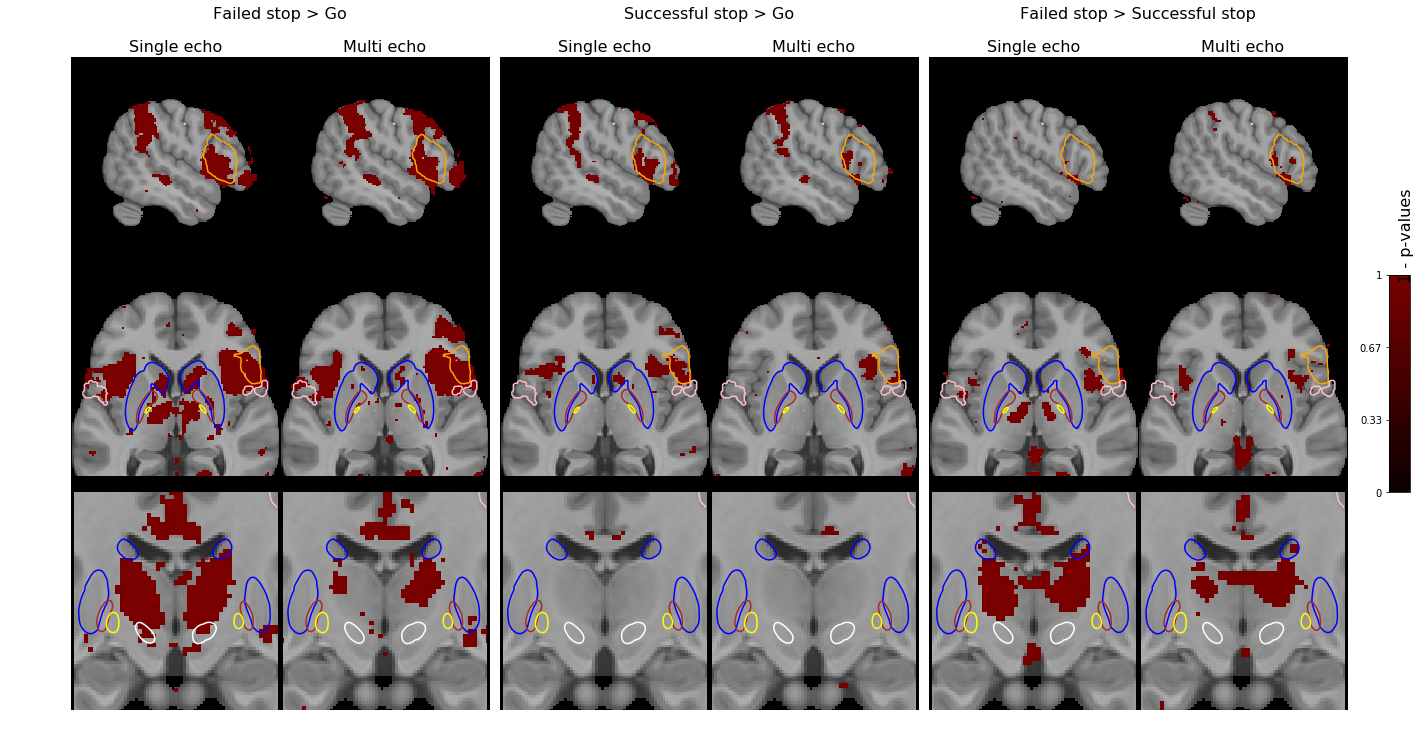

In [182]:
from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1, 1, 0.05, 1, 1, .05, 1, 1, .1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps_combined)+5, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps_combined)+5, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_secondlevel_results(zmaps_combined, roi_dict, z_threshold=0,
                                          f=f, axes=axes,
                                          roi_to_plot=['rIFG', 'STR', 'STN'],
                                          cut_coords=[[52], None, [-13]],
                                          bg_img='/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii',
                                          vmax=6, #colorbar=False, 
                                          annotate=False, empty_plots=False, 
                                          skip_all_but_last=False)
axes[0,0].set_title('Single echo', size=16)
axes[0,1].set_title('Multi echo', size=16)
axes[0,3].set_title('Single echo', size=16)
axes[0,4].set_title('Multi echo', size=16)
axes[0,6].set_title('Single echo', size=16)
axes[0,7].set_title('Multi echo', size=16)

for row in range(axes.shape[0]):
    axes[row,2].set_visible(False)
    axes[row,5].set_visible(False)
    axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)
    
# for titles: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
ext = []
#loop over the columns (j) and rows(i) to populate subplots
for j in range(8):
    # save the axes bounding boxes for later use
    ext.append([axes[0,j].get_window_extent().x0, axes[0,j].get_window_extent().width ])

# make nice
inv = f.transFigure.inverted()
width_left = ext[0][0]+(ext[1][0]+ext[1][1]-ext[0][0])/2.
left_center = inv.transform( (width_left, 1) )

width_mid = ext[3][0]+(ext[4][0]+ext[4][1]-ext[3][0])/2.
mid_center = inv.transform( (width_mid, 1) )

width_right = ext[6][0]+(ext[7][0]+ext[7][1]-ext[6][0])/2.
right_center = inv.transform( (width_right, 1) )

# set column spanning title 
# the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
plt.figtext(left_center[0], .93, "Failed stop > Go", va="center", ha="center", size=16)
plt.figtext(mid_center[0], .93, "Successful stop > Go", va="center", ha="center", size=16)
plt.figtext(right_center[0], .93, "Failed stop > Successful stop", va="center", ha="center", size=16)


# colorbar
#cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax2 = f.add_subplot(gs[1,-1])

#cbar_ax1 = _draw_colorbarSM2(colorbar_ax=cbar_ax1, truncation_limits=(3,6), offset=0, flip=False)
cbar_ax2 = _draw_colorbarSM2(colorbar_ax=cbar_ax2, truncation_limits=(0, 1), offset=.001, flip=False)
cbar_ax2.set_title('1 - p-values', rotation=90, fontsize=16, ha='left', pad=75)

# f.savefig('./glm.pdf')#, bbox_inches='tight')

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


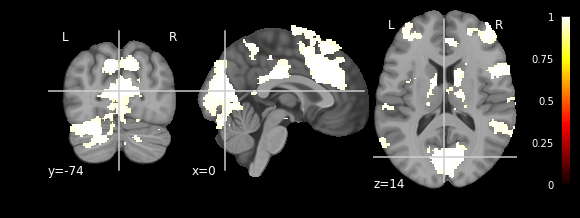

In [115]:
plotting.plot_stat_map(nib.load('./lisa_second_level/me/second_level_contrast-failed-go.nii'),
                      bg_img='/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii')

In [130]:
plotting.plot_stat_map(
    nib.load('./lisa_second_level/me/second_level_contrast-failed-success.nii'),
    bg_img='/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii')

FileNotFoundError: No such file or no access: './lisa_second_level/me/second_level_contrast-failed-success.nii'

In [ ]:
# build command
#docker run -v /home/stevenm/MultiEchoEPISeq/lisa_second_level/me:/data lipsia vlisa_onesample -in /data/sub-1_ses-me_contrast-failed-go_stat-t.nii.gz /data/sub-2_ses-me_contrast-failed-go_stat-t.nii.gz -out /data/second_level_contrast-failed-go.v

In [52]:
## Run lisa via docker
# docker run -v ${dir}:${dir} lipsia vecm -in ${dir}/fmri.v -mask ${dir}/mask.v -out ${dir}/ecm.v
#!docker run -v /home/stevenm/MultiEchoEPISeq/lisa_second_level/me:/home/stevenm/MultiEchoEPISeq/lisa_second_level/me vlisa_onesample -in sub-*_ses-me_contrast-failed-go_stat-t.nii.gz -out second_level_contrast-failed-go.v

docker: Got permission denied while trying to connect to the Docker daemon socket at unix:///var/run/docker.sock: Post http://%2Fvar%2Frun%2Fdocker.sock/v1.39/containers/create: dial unix /var/run/docker.sock: connect: permission denied.
See 'docker run --help'.


In [ ]:
# me_t_maps_failed_go
# se_t_maps_failed_go
# me_t_maps_failed_success
# se_t_maps_failed_success
# me_t_maps_success_go
# se_t_maps_success_go


In [33]:
# sub = 1
# n_jobs = 1

# session = 'se'
# sub_str = str(sub).zfill(2)

# all_t_maps = []

# for sub in np.arange(1, 19):
#     if sub == 12:
#         continue
        
#     model = FirstLevels(sub_str, session, 
#                 bids_root='./data/deriv/fmriprep/', 
#                 bold_space='MNI152NLin2009cAsym',
#                 runs=runs, highpassed_data=True)
#     model.fit_first_level(n_jobs=n_jobs, include_confounds=include_confounds, smoothing_fwhm=0,
#                           drift_model=None, overwrite=overwrite)
#     model.compute_contrasts(contrasts, overwrite=overwrite)

False
./data/deriv/fmriprep/sub-01/ses-se/func/../model_nistats-upgraded
./data/deriv/fmriprep/sub-01/ses-se/func/../model_nistats-upgraded/firstlevel_fwhm-0.pkl
Model already exists, loading from file...
Contrast file found, loading from file...


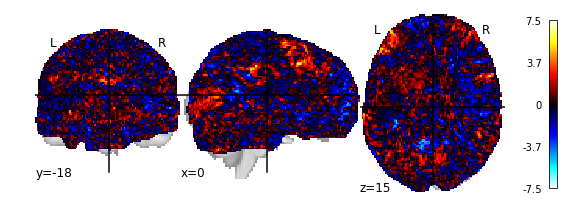

In [40]:

plotting.plot_stat_map(
        model.first_level_model.compute_contrast(['failed_stop - go_trial'], stat_type='t', output_type='stat'))

In [163]:
# def _draw_colorbarSM2(colorbar_ax, vmin=3, vmax=6, truncation_limits=(0,6), offset=4., nb_ticks=4, flip=True):
#     from matplotlib.colorbar import ColorbarBase
#     from matplotlib import colors
#     our_cmap = plotting.cm.cold_hot
#     if flip:
#         truncation_limits = [truncation_limits[1], truncation_limits[0]]
#     ticks = np.linspace(truncation_limits[0], truncation_limits[1], nb_ticks)
#     bounds = np.linspace(truncation_limits[0], truncation_limits[1], our_cmap.N)
#     norm = colors.Normalize(vmin=-vmax, vmax=vmax)
    
#     # some colormap hacking
#     cmaplist = [our_cmap(i) for i in range(our_cmap.N)]
#     istart = int(norm(-offset, clip=True) * (our_cmap.N - 1))
#     istop = int(norm(offset, clip=True) * (our_cmap.N - 1))
#     for i in range(istart, istop):
#         cmaplist[i] = (0.5, 0.5, 0.5, 1.)  # just an average gray color
#     our_cmap = our_cmap.from_list('Custom cmap', cmaplist, our_cmap.N)

#     ColorbarBase(colorbar_ax, ticks=ticks, norm=norm,
#                  orientation='vertical', cmap=our_cmap, boundaries=bounds,
#                  spacing='proportional', format='%.2g')
    
#     if flip:
#         colorbar_ax.invert_yaxis()
#         colorbar_ax.yaxis.tick_right()
#     else:
#         colorbar_ax.yaxis.tick_left()

# #     tick_color = 'w'
# #     for tick in colorbar_ax.yaxis.get_ticklabels():
# #         tick.set_color(tick_color)
# #     colorbar_ax.yaxis.set_tick_params(width=0)
#     return colorbar_ax

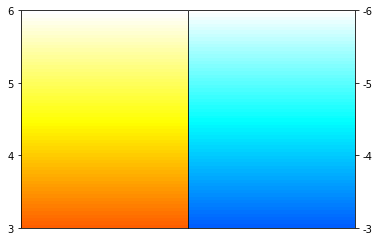

In [164]:
# tmp_f, tmp_ax = plt.subplots(1, 2, gridspec_kw={'wspace': 0})
# ax_tmp = _draw_colorbarSM2(colorbar_ax=tmp_ax[0], truncation_limits=(3,6), offset=thresholds_combined[0], flip=False)
# ax_tmp = _draw_colorbarSM2(colorbar_ax=tmp_ax[1], truncation_limits=(-3,-6), offset=thresholds_combined[0], flip=True)
# tmp_f.show()

In [ ]:
ax_tmp.set_ylim

In [ ]:
f.gri

In [489]:
len(zmaps_combined)*4, 12

(24, 12)

In [482]:
disps[-1].__dict__

{'cut_coords': [-6.464108817452171],
 'frame_axes': <matplotlib.axes._subplots.AxesSubplot at 0x7eea3f7f8eb8>,
 'rect': (0.7729508196721311,
  0.1250000000000001,
  0.8999999999999999,
  0.3766666666666667),
 '_black_bg': True,
 '_brain_color': (0.5, 0.5, 0.5),
 '_colorbar': True,
 '_colorbar_width': 0.006352459016393442,
 '_colorbar_margin': {'left': 0.03176229508196721,
  'right': 0.0025409836065573765,
  'top': 0.01258333333333333,
  'bottom': 0.01258333333333333},
 'axes': {-6.464108817452171: <nilearn.plotting.displays.CutAxes at 0x7eea3edcc7f0>}}

[52]
x
[8.030823192873697]
z
[-6.464108817452171]
z


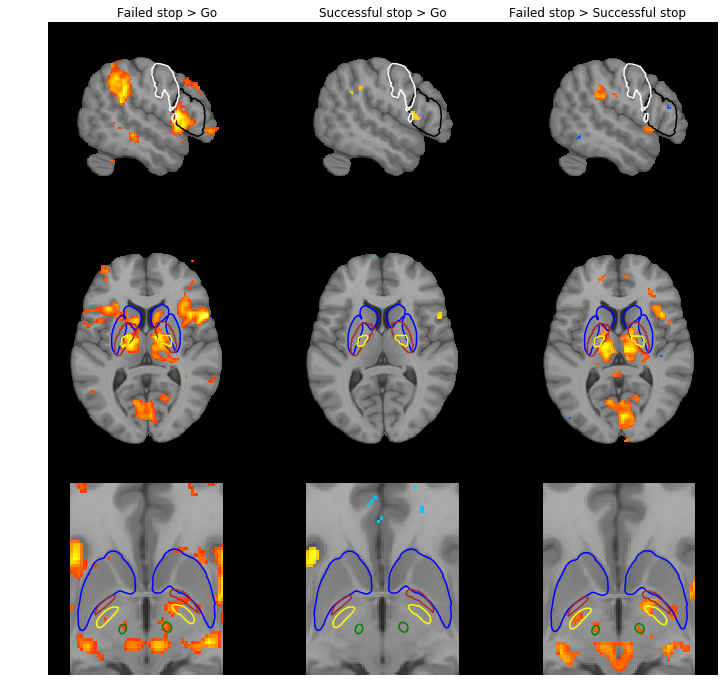

In [457]:
f, axes = plot_secondlevel_results(zmaps_se, roi_dict, z_threshold=thresholds_se,
                                   roi_to_plot=['rIFG', 'STR', 'STN'],
                                   cut_coords=[[52], None, None],
                                   bg_img='/home/stevenm/Templates/mni_icbm152_t1_tal_nlin_asym_09a_brain.nii.gz',
                                   vmax=6, colorbar=False, annotate=False)
axes[0,0].set_title('Failed stop > Go')
axes[0,1].set_title('Successful stop > Go')
axes[0,2].set_title('Failed stop > Successful stop')
f.subplots_adjust(hspace=-.1, wspace=-.1)

In [ ]:
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


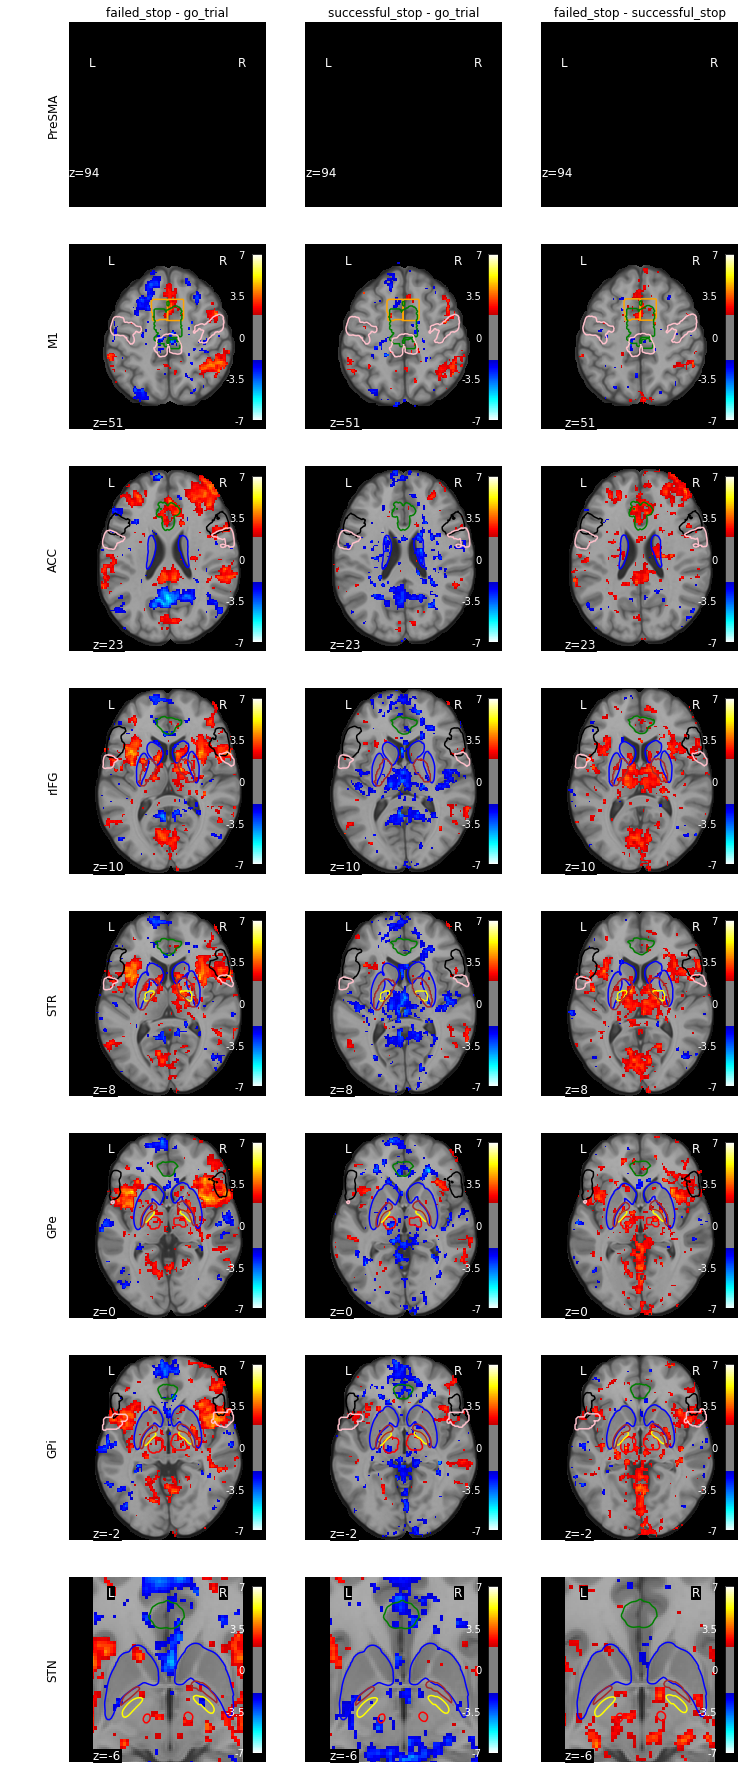

In [309]:
f = plot_secondlevel_results(zmaps_me, roi_dict, z_threshold=2,
                             bg_img='/home/stevenm/Templates/mni_icbm152_t1_tal_nlin_asym_09a_brain.nii.gz',
                             vmax=7)

In [ ]:
plotting.plot_stat_map(zmaps_me['failed_stop - go_trial'], 
                       bg_img='/home/stevenm/Templates/mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm.nii.gz',
                       threshold=2.58)

In [ ]:
plotting.plot_stat_map(zmaps_se['failed_stop - go_trial'], 
                       bg_img='/home/stevenm/Templates/mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm.nii.gz',
                       threshold=2.58)